# Model 7: Vanilla CNN for Depth Regression

---

**Architecture**
- 5-layer Convolutional Neural Network
- Single regression head for depth estimation
- Shared backbone for feature extraction

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)


## 1. Setup & Data Loading

In [18]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Optuna for hyperparameter tuning
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice
)

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.depth_dataset import RegressDataset

# Import regression utilities
from src.utils.regression_utils import (
    train_epoch_regression,
    validate_epoch_regression,
    collect_predictions_regression,
    compute_regression_metrics,
    RegressionMetricsTracker,
    plot_regression_training_curves,
    plot_predictions_vs_actual,
    plot_residuals,
    plot_error_distribution,
    plot_depth_predictions_gallery
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries and utilities imported successfully")

Using device: mps
All libraries and utilities imported successfully


### Load Dataset & Create Splits

For regression, we use a simple random split (60/20/20) without stratification.

In [3]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = RegressDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")

# Check a sample
sample_img, sample_depth = full_dataset[0]
print(f"\nSample image shape: {sample_img.shape}")
print(f"Sample depth value: {sample_depth.item():.4f}")

Total samples: 2000

Sample image shape: torch.Size([3, 224, 224])
Sample depth value: 0.7850


In [4]:
# Create random splits (60/20/20)
from sklearn.model_selection import train_test_split

# Get all indices
all_indices = list(range(len(full_dataset)))

# First split: 80% train+val, 20% test
train_val_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42
)

# Second split: 75% of train+val becomes train (60% of total), 25% becomes val (20% of total)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of total
    random_state=42
)

print(f"Split sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")

Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [5]:
# Verify depth distribution across splits
train_depths = [full_dataset[i][1].item() for i in train_idx]
val_depths = [full_dataset[i][1].item() for i in val_idx]
test_depths = [full_dataset[i][1].item() for i in test_idx]

print("\nDepth Statistics:")
print(f"Train - Min: {min(train_depths):.3f}, Max: {max(train_depths):.3f}, Mean: {np.mean(train_depths):.3f}")
print(f"Val   - Min: {min(val_depths):.3f}, Max: {max(val_depths):.3f}, Mean: {np.mean(val_depths):.3f}")
print(f"Test  - Min: {min(test_depths):.3f}, Max: {max(test_depths):.3f}, Mean: {np.mean(test_depths):.3f}")


Depth Statistics:
Train - Min: 0.000, Max: 1.000, Mean: 0.441
Val   - Min: 0.000, Max: 0.998, Mean: 0.435
Test  - Min: 0.000, Max: 1.000, Mean: 0.457


In [6]:
# Create dataset splits with augmentation for training
train_dataset = RegressDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = RegressDataset(rootpath=str(data_root), augment=False)
test_dataset = RegressDataset(rootpath=str(data_root), augment=False)

# Create subsets
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)
test_subset = Subset(test_dataset, test_idx)

# Create dataloaders
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

Datasets and loaders created
   Train batches: 19
   Val batches: 7
   Test batches: 7


## 2. Model Architecture

**Vanilla CNN for Regression:**
- 5 convolutional layers with increasing channels
- MaxPooling for downsampling
- Batch normalization for stability
- Dropout for regularization
- Single regression head outputting continuous depth value

In [7]:
class VanillaCNN_Regression(nn.Module):
    """
    5-layer Vanilla CNN for depth regression
    
    Args:
        channels: List of channel sizes for each conv layer
        fc_dim: Fully connected layer dimension
        dropout_rate: Dropout probability
        use_bn: Use batch normalization
    """
    
    def __init__(
        self,
        channels=[32, 64, 128, 256, 512],
        fc_dim=256,
        dropout_rate=0.3,
        use_bn=True
    ):
        super(VanillaCNN_Regression, self).__init__()
        
        self.use_bn = use_bn
        
        # Feature extraction backbone (5 conv blocks)
        self.features = nn.ModuleList()
        
        in_channels = 3
        for out_channels in channels:
            block = []
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_bn:
                block.append(nn.BatchNorm2d(out_channels))
            block.append(nn.ReLU(inplace=True))
            block.append(nn.MaxPool2d(2, 2))
            
            self.features.append(nn.Sequential(*block))
            in_channels = out_channels
        
        # Adaptive pooling to handle variable spatial sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Shared fully connected layer
        self.fc_shared = nn.Sequential(
            nn.Linear(channels[-1], fc_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
        # Regression head (outputs single continuous value)
        self.regression_head = nn.Linear(fc_dim, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        # Feature extraction
        for block in self.features:
            x = block(x)
        
        # Global average pooling
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        
        # Shared features
        features = self.fc_shared(x)
        
        # Regression output
        depth_out = self.regression_head(features)
        
        if return_features:
            return depth_out, features
        return depth_out
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
# Test model
test_model = VanillaCNN_Regression()
test_input = torch.randn(1, 3, 224, 224)
depth_out = test_model(test_input)

print(f"Model architecture defined")
print(f"   Input shape: {test_input.shape}")
print(f"   Depth output shape: {depth_out.shape}")
print(f"   Total parameters: {test_model.get_num_params():,}")

del test_model, test_input, depth_out

Model architecture defined
   Input shape: torch.Size([1, 3, 224, 224])
   Depth output shape: torch.Size([1, 1])
   Total parameters: 1,702,145


## 3. Training (Baseline)

First training run with default hyperparameters to establish baseline performance.

In [10]:
# Initialize baseline model
model = VanillaCNN_Regression(
    channels=[32, 64, 128, 256, 512],
    fc_dim=256,
    dropout_rate=0.3,
    use_bn=True
).to(device)

# Loss function for regression
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# Metrics tracker
tracker = RegressionMetricsTracker()

print(f"Model initialized with {model.get_num_params():,} parameters")
print(f"Criterion: MSELoss")
print(f"Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)")
print(f"Scheduler: CosineAnnealingWarmRestarts")

Model initialized with 1,702,145 parameters
Criterion: MSELoss
Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
Scheduler: CosineAnnealingWarmRestarts


In [10]:
# Training configuration
num_epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

print(f"Starting baseline training for {num_epochs} epochs...")
print(f"Early stopping patience: {patience}\n")

for epoch in range(num_epochs):
    # Train
    train_metrics = train_epoch_regression(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update tracker
    tracker.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}")
        print(f"  LR: {current_lr:.6f}")
    
    # Early stopping
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict()
        print(f"  -> New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(best_model_state)

Starting baseline training for 100 epochs...
Early stopping patience: 20

Epoch [1/100]
  Train - Loss: 0.0181, RMSE: 0.1347, MAE: 0.1006
  Val   - Loss: 0.2133, RMSE: 0.4618, MAE: 0.3806
  LR: 0.000905
  -> New best validation loss: 0.2133
  -> New best validation loss: 0.0171
  -> New best validation loss: 0.0169
Epoch [5/100]
  Train - Loss: 0.0130, RMSE: 0.1138, MAE: 0.0847
  Val   - Loss: 0.0408, RMSE: 0.2019, MAE: 0.1659
  LR: 0.000346
  -> New best validation loss: 0.0155
  -> New best validation loss: 0.0075
Epoch [10/100]
  Train - Loss: 0.0125, RMSE: 0.1120, MAE: 0.0843
  Val   - Loss: 0.0756, RMSE: 0.2749, MAE: 0.2541
  LR: 0.000994
  -> New best validation loss: 0.0074
Epoch [15/100]
  Train - Loss: 0.0113, RMSE: 0.1061, MAE: 0.0797
  Val   - Loss: 0.0233, RMSE: 0.1525, MAE: 0.1229
  LR: 0.000794
  -> New best validation loss: 0.0066
Epoch [20/100]
  Train - Loss: 0.0085, RMSE: 0.0921, MAE: 0.0675
  Val   - Loss: 0.0188, RMSE: 0.1373, MAE: 0.1143
  LR: 0.000422
  -> New bes

<All keys matched successfully>

In [ ]:
# Save baseline model
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

baseline_model_path = models_dir / '5_vanilla_cnn_depth_baseline.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'tracker_history': tracker.get_history()
}, baseline_model_path)

print(f"Baseline model saved to: {baseline_model_path}")

Baseline model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/7_vanilla_cnn_depth_baseline.pth


## 4. Evaluation & Analysis

Comprehensive evaluation of the baseline model.

### 4.1 Training Curves

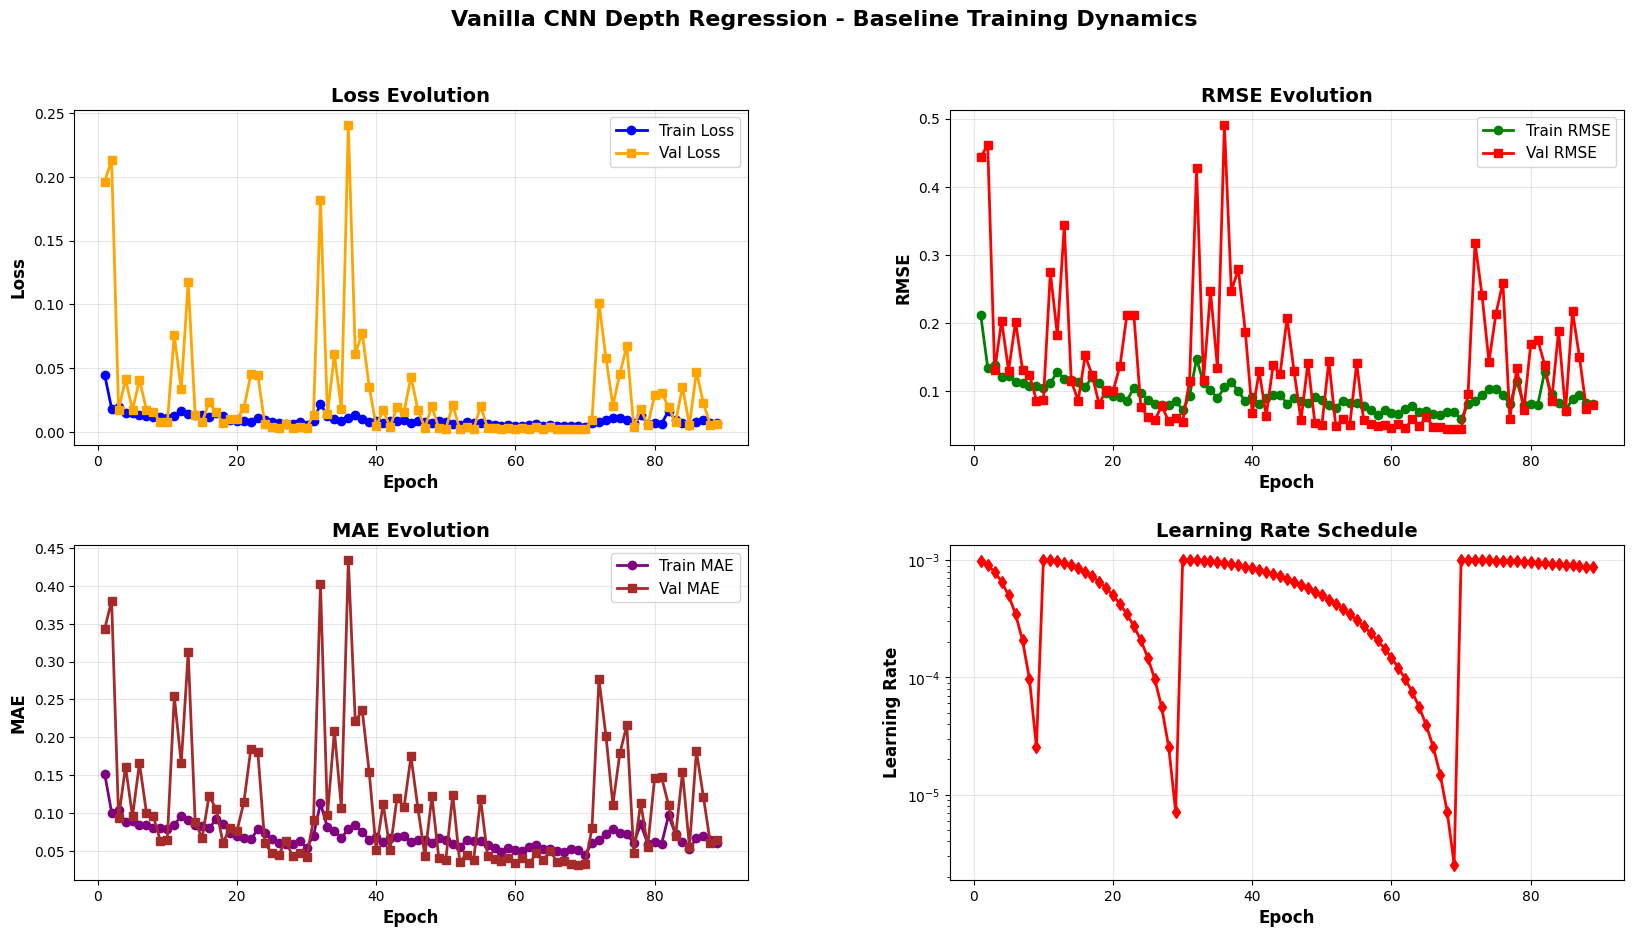

In [12]:
# Plot training curves
reports_dir = project_root / 'reports'
reports_dir.mkdir(exist_ok=True)

plot_regression_training_curves(
    tracker_history=tracker.get_history(),
    save_path=reports_dir / '7_vanilla_cnn_depth_baseline_training_curves.png',
    title='Vanilla CNN Depth Regression - Baseline Training Dynamics'
)

### 4.2 Test Set Evaluation

In [13]:
# Collect predictions on test set
test_results = collect_predictions_regression(
    model=model,
    dataloader=test_loader,
    device=device,
    return_images=True
)

print("Test set predictions collected")
print(f"   Predictions shape: {test_results['predictions'].shape}")
print(f"   Targets shape: {test_results['targets'].shape}")
print(f"   Images shape: {test_results['images'].shape}")

Test set predictions collected
   Predictions shape: (400,)
   Targets shape: (400,)
   Images shape: (400, 3, 224, 224)


In [14]:
# Compute comprehensive metrics
test_metrics = compute_regression_metrics(
    predictions=test_results['predictions'],
    targets=test_results['targets']
)

print("\nTest Set Performance:")
print("="*50)
print(f"MSE:           {test_metrics['mse']:.6f}")
print(f"RMSE:          {test_metrics['rmse']:.6f}")
print(f"MAE:           {test_metrics['mae']:.6f}")
print(f"Median AE:     {test_metrics['median_ae']:.6f}")
print(f"R²:            {test_metrics['r2']:.6f}")
print(f"Max Error:     {test_metrics['max_error']:.6f}")
print(f"Std Error:     {test_metrics['std_error']:.6f}")
if 'mape' in test_metrics:
    print(f"MAPE:          {test_metrics['mape']:.2f}%")
print("="*50)


Test Set Performance:
MSE:           0.007001
RMSE:          0.083674
MAE:           0.068694
Median AE:     0.065523
R²:            0.930115
Max Error:     0.191899
Std Error:     0.059121


### 4.4 Residual Analysis

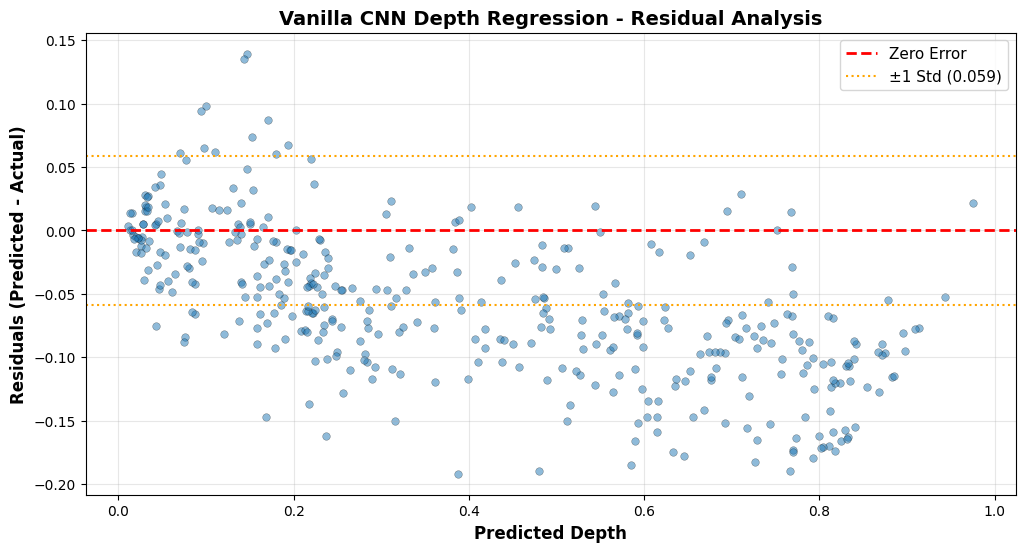

In [16]:
plot_residuals(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / '7_vanilla_cnn_depth_baseline_residuals.png',
    title='Vanilla CNN Depth Regression - Residual Analysis'
)

### 4.5 Error Distribution

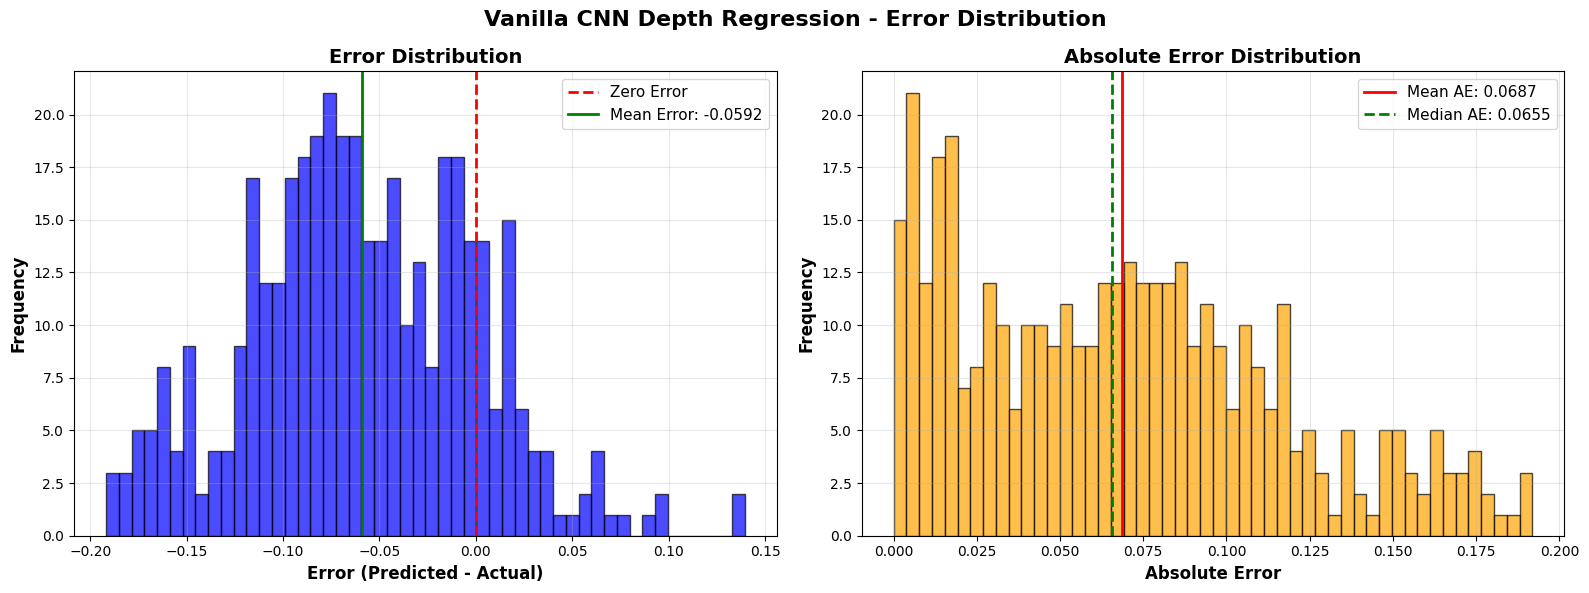

In [18]:
plot_error_distribution(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / '7_vanilla_cnn_depth_baseline_error_distribution.png',
    title='Vanilla CNN Depth Regression - Error Distribution'
)

## 5. Hyperparameter Tuning (Optuna)

Systematic search for optimal hyperparameters using Optuna (~50 trials).

In [19]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization
    """
    # Hyperparameters to tune
    channels_option = trial.suggest_categorical('channels', [
        [32, 64, 128, 256, 512],
        [16, 32, 64, 128, 256],
        [64, 128, 256, 512, 1024]
    ])
    fc_dim = trial.suggest_categorical('fc_dim', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    use_bn = trial.suggest_categorical('use_bn', [True, False])
    
    # Create model
    trial_model = VanillaCNN_Regression(
        channels=channels_option,
        fc_dim=fc_dim,
        dropout_rate=dropout_rate,
        use_bn=use_bn
    ).to(device)
    
    # Create dataloaders with trial batch size
    trial_train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    trial_val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )
    
    # Loss and optimizer
    trial_criterion = nn.MSELoss()
    trial_optimizer = torch.optim.AdamW(
        trial_model.parameters(),
        lr=lr,
        weight_decay=1e-4
    )
    
    # Train for limited epochs
    num_trial_epochs = 20
    best_val_rmse = float('inf')
    
    for epoch in range(num_trial_epochs):
        # Train
        train_metrics = train_epoch_regression(
            model=trial_model,
            dataloader=trial_train_loader,
            criterion=trial_criterion,
            optimizer=trial_optimizer,
            device=device
        )
        
        # Validate
        val_metrics = validate_epoch_regression(
            model=trial_model,
            dataloader=trial_val_loader,
            criterion=trial_criterion,
            device=device
        )
        
        # Track best RMSE
        if val_metrics['rmse'] < best_val_rmse:
            best_val_rmse = val_metrics['rmse']
        
        # Report intermediate value for pruning
        trial.report(best_val_rmse, epoch)
        
        # Prune trial if not promising
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_rmse

print("Optuna objective function defined")

Optuna objective function defined


In [20]:
# Create and run study
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

print("Starting Optuna hyperparameter search...")
print("Target: ~50 trials\n")

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nOptimization completed!")
print(f"Number of finished trials: {len(study.trials)}")
print(f"\nBest trial:")
print(f"  Value (Val RMSE): {study.best_trial.value:.6f}")
print(f"  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-09 14:28:17,337] A new study created in memory with name: no-name-a1c77580-df1e-426b-a3e2-c8d43033e69b


Starting Optuna hyperparameter search...
Target: ~50 trials



Best trial: 0. Best value: 0.124006:   2%|▏         | 1/50 [05:25<4:25:39, 325.30s/it]

[I 2025-12-09 14:33:42,603] Trial 0 finished with value: 0.12400586732174998 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 256, 'dropout_rate': 0.3316873460318934, 'lr': 6.90288545068312e-05, 'batch_size': 128, 'use_bn': False}. Best is trial 0 with value: 0.12400586732174998.


Best trial: 1. Best value: 0.0832853:   4%|▍         | 2/50 [18:00<7:42:40, 578.35s/it]

[I 2025-12-09 14:46:18,084] Trial 1 finished with value: 0.08328528936584893 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 128, 'dropout_rate': 0.25345108164571734, 'lr': 0.002200579455655057, 'batch_size': 128, 'use_bn': True}. Best is trial 1 with value: 0.08328528936584893.


Best trial: 1. Best value: 0.0832853:   6%|▌         | 3/50 [19:16<4:33:09, 348.71s/it]

[I 2025-12-09 14:47:33,565] Trial 2 finished with value: 0.10201182630351775 and parameters: {'channels': [16, 32, 64, 128, 256], 'fc_dim': 128, 'dropout_rate': 0.1129153424469624, 'lr': 0.007510001068398608, 'batch_size': 64, 'use_bn': False}. Best is trial 1 with value: 0.08328528936584893.


Best trial: 1. Best value: 0.0832853:   8%|▊         | 4/50 [24:35<4:18:28, 337.14s/it]

[I 2025-12-09 14:52:52,956] Trial 3 finished with value: 0.09769054821436407 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 512, 'dropout_rate': 0.485138001333632, 'lr': 0.00032362588202829656, 'batch_size': 64, 'use_bn': False}. Best is trial 1 with value: 0.08328528936584893.


Best trial: 4. Best value: 0.069532:  10%|█         | 5/50 [31:20<4:31:08, 361.53s/it] 

[I 2025-12-09 14:59:37,744] Trial 4 finished with value: 0.069532040728134 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 128, 'dropout_rate': 0.3903271738517074, 'lr': 0.00025552818098582684, 'batch_size': 32, 'use_bn': True}. Best is trial 4 with value: 0.069532040728134.


Best trial: 4. Best value: 0.069532:  12%|█▏        | 6/50 [31:57<3:04:07, 251.07s/it]

[I 2025-12-09 15:00:14,397] Trial 5 pruned. 


Best trial: 4. Best value: 0.069532:  14%|█▍        | 7/50 [36:02<2:58:33, 249.16s/it]

[I 2025-12-09 15:04:19,599] Trial 6 pruned. 


Best trial: 4. Best value: 0.069532:  16%|█▌        | 8/50 [36:24<2:03:47, 176.85s/it]

[I 2025-12-09 15:04:41,647] Trial 7 pruned. 


Best trial: 4. Best value: 0.069532:  18%|█▊        | 9/50 [36:45<1:27:36, 128.21s/it]

[I 2025-12-09 15:05:02,911] Trial 8 pruned. 


Best trial: 4. Best value: 0.069532:  20%|██        | 10/50 [39:29<1:32:51, 139.28s/it]

[I 2025-12-09 15:07:46,983] Trial 9 finished with value: 0.08826249206062382 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 256, 'dropout_rate': 0.2709865193963567, 'lr': 0.0021959422703392503, 'batch_size': 32, 'use_bn': True}. Best is trial 4 with value: 0.069532040728134.


Best trial: 4. Best value: 0.069532:  22%|██▏       | 11/50 [40:41<1:17:10, 118.72s/it]

[I 2025-12-09 15:08:59,078] Trial 10 pruned. 


Best trial: 4. Best value: 0.069532:  24%|██▍       | 12/50 [43:34<1:25:32, 135.06s/it]

[I 2025-12-09 15:11:51,513] Trial 11 pruned. 


Best trial: 4. Best value: 0.069532:  26%|██▌       | 13/50 [47:38<1:43:39, 168.09s/it]

[I 2025-12-09 15:15:55,573] Trial 12 pruned. 


Best trial: 4. Best value: 0.069532:  28%|██▊       | 14/50 [51:29<1:52:14, 187.08s/it]

[I 2025-12-09 15:19:46,546] Trial 13 pruned. 


Best trial: 4. Best value: 0.069532:  30%|███       | 15/50 [57:45<2:22:21, 244.05s/it]

[I 2025-12-09 15:26:02,647] Trial 14 finished with value: 0.07933427241224794 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 128, 'dropout_rate': 0.408387123194012, 'lr': 0.0007514417016532713, 'batch_size': 32, 'use_bn': True}. Best is trial 4 with value: 0.069532040728134.


Best trial: 4. Best value: 0.069532:  32%|███▏      | 16/50 [59:33<1:55:06, 203.13s/it]

[I 2025-12-09 15:27:50,747] Trial 15 pruned. 


Best trial: 4. Best value: 0.069532:  34%|███▍      | 17/50 [1:01:14<1:34:52, 172.50s/it]

[I 2025-12-09 15:29:32,030] Trial 16 pruned. 


Best trial: 4. Best value: 0.069532:  36%|███▌      | 18/50 [1:07:27<2:04:10, 232.84s/it]

[I 2025-12-09 15:35:45,323] Trial 17 finished with value: 0.08230656449251113 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 128, 'dropout_rate': 0.4409573099078833, 'lr': 0.000710608196781647, 'batch_size': 32, 'use_bn': True}. Best is trial 4 with value: 0.069532040728134.


Best trial: 4. Best value: 0.069532:  38%|███▊      | 19/50 [1:11:23<2:00:38, 233.51s/it]

[I 2025-12-09 15:39:40,399] Trial 18 pruned. 


Best trial: 4. Best value: 0.069532:  40%|████      | 20/50 [1:13:56<1:44:39, 209.33s/it]

[I 2025-12-09 15:42:13,374] Trial 19 finished with value: 0.07232577089173454 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.3572986329785448, 'lr': 0.00020750828144996708, 'batch_size': 32, 'use_bn': True}. Best is trial 4 with value: 0.069532040728134.


Best trial: 20. Best value: 0.0618367:  42%|████▏     | 21/50 [1:16:35<1:33:58, 194.43s/it]

[I 2025-12-09 15:44:53,079] Trial 20 finished with value: 0.061836692831953054 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.34251086540581305, 'lr': 0.00018130427581433087, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  44%|████▍     | 22/50 [1:17:41<1:12:40, 155.73s/it]

[I 2025-12-09 15:45:58,548] Trial 21 pruned. 


Best trial: 20. Best value: 0.0618367:  46%|████▌     | 23/50 [1:18:43<57:31, 127.82s/it]  

[I 2025-12-09 15:47:01,258] Trial 22 pruned. 


Best trial: 20. Best value: 0.0618367:  48%|████▊     | 24/50 [1:21:15<58:26, 134.87s/it]

[I 2025-12-09 15:49:32,572] Trial 23 finished with value: 0.07002629669044184 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.3742313923743384, 'lr': 6.755179205474071e-05, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  50%|█████     | 25/50 [1:23:49<58:36, 140.66s/it]

[I 2025-12-09 15:52:06,751] Trial 24 finished with value: 0.06948355474774942 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.38544905984702615, 'lr': 6.69108960604537e-05, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  52%|█████▏    | 26/50 [1:24:35<44:56, 112.35s/it]

[I 2025-12-09 15:52:53,034] Trial 25 pruned. 


Best trial: 20. Best value: 0.0618367:  54%|█████▍    | 27/50 [1:25:20<35:17, 92.07s/it] 

[I 2025-12-09 15:53:37,784] Trial 26 pruned. 


Best trial: 20. Best value: 0.0618367:  56%|█████▌    | 28/50 [1:26:04<28:31, 77.81s/it]

[I 2025-12-09 15:54:22,339] Trial 27 pruned. 


Best trial: 20. Best value: 0.0618367:  58%|█████▊    | 29/50 [1:27:05<25:22, 72.50s/it]

[I 2025-12-09 15:55:22,463] Trial 28 pruned. 


Best trial: 20. Best value: 0.0618367:  60%|██████    | 30/50 [1:27:41<20:30, 61.54s/it]

[I 2025-12-09 15:55:58,424] Trial 29 pruned. 


Best trial: 20. Best value: 0.0618367:  62%|██████▏   | 31/50 [1:28:06<16:01, 50.62s/it]

[I 2025-12-09 15:56:23,550] Trial 30 pruned. 


Best trial: 20. Best value: 0.0618367:  64%|██████▍   | 32/50 [1:28:58<15:20, 51.16s/it]

[I 2025-12-09 15:57:15,979] Trial 31 pruned. 


Best trial: 20. Best value: 0.0618367:  66%|██████▌   | 33/50 [1:29:58<15:15, 53.84s/it]

[I 2025-12-09 15:58:16,063] Trial 32 pruned. 


Best trial: 20. Best value: 0.0618367:  68%|██████▊   | 34/50 [1:30:58<14:51, 55.69s/it]

[I 2025-12-09 15:59:16,071] Trial 33 pruned. 


Best trial: 20. Best value: 0.0618367:  70%|███████   | 35/50 [1:31:51<13:40, 54.73s/it]

[I 2025-12-09 16:00:08,575] Trial 34 pruned. 


Best trial: 20. Best value: 0.0618367:  72%|███████▏  | 36/50 [1:32:26<11:24, 48.92s/it]

[I 2025-12-09 16:00:43,915] Trial 35 pruned. 


Best trial: 20. Best value: 0.0618367:  74%|███████▍  | 37/50 [1:32:51<09:03, 41.84s/it]

[I 2025-12-09 16:01:09,245] Trial 36 pruned. 


Best trial: 20. Best value: 0.0618367:  76%|███████▌  | 38/50 [1:33:27<08:01, 40.10s/it]

[I 2025-12-09 16:01:45,269] Trial 37 pruned. 


Best trial: 20. Best value: 0.0618367:  78%|███████▊  | 39/50 [1:35:35<12:11, 66.48s/it]

[I 2025-12-09 16:03:53,329] Trial 38 pruned. 


Best trial: 20. Best value: 0.0618367:  80%|████████  | 40/50 [1:35:56<08:48, 52.81s/it]

[I 2025-12-09 16:04:14,244] Trial 39 pruned. 


Best trial: 20. Best value: 0.0618367:  82%|████████▏ | 41/50 [1:36:45<07:44, 51.57s/it]

[I 2025-12-09 16:05:02,922] Trial 40 pruned. 


Best trial: 20. Best value: 0.0618367:  84%|████████▍ | 42/50 [1:37:33<06:42, 50.35s/it]

[I 2025-12-09 16:05:50,414] Trial 41 pruned. 


Best trial: 20. Best value: 0.0618367:  86%|████████▌ | 43/50 [1:40:09<09:34, 82.05s/it]

[I 2025-12-09 16:08:26,439] Trial 42 finished with value: 0.06458445527687812 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.38698680522367246, 'lr': 0.0002533582237321934, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  88%|████████▊ | 44/50 [1:42:39<10:15, 102.60s/it]

[I 2025-12-09 16:10:56,971] Trial 43 finished with value: 0.06597608829799914 and parameters: {'channels': [32, 64, 128, 256, 512], 'fc_dim': 512, 'dropout_rate': 0.3863007635112323, 'lr': 0.0002841620995579262, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  90%|█████████ | 45/50 [1:43:24<07:06, 85.29s/it] 

[I 2025-12-09 16:11:41,879] Trial 44 pruned. 


Best trial: 20. Best value: 0.0618367:  92%|█████████▏| 46/50 [1:49:26<11:13, 168.39s/it]

[I 2025-12-09 16:17:44,154] Trial 45 finished with value: 0.07422140668832339 and parameters: {'channels': [64, 128, 256, 512, 1024], 'fc_dim': 128, 'dropout_rate': 0.23891473577790306, 'lr': 0.0005089130924174276, 'batch_size': 32, 'use_bn': True}. Best is trial 20 with value: 0.061836692831953054.


Best trial: 20. Best value: 0.0618367:  94%|█████████▍| 47/50 [1:50:19<06:40, 133.66s/it]

[I 2025-12-09 16:18:36,793] Trial 46 pruned. 


Best trial: 20. Best value: 0.0618367:  96%|█████████▌| 48/50 [1:50:39<03:19, 99.53s/it] 

[I 2025-12-09 16:18:56,679] Trial 47 pruned. 


Best trial: 20. Best value: 0.0618367:  98%|█████████▊| 49/50 [1:53:48<02:06, 126.42s/it]

[I 2025-12-09 16:22:05,818] Trial 48 pruned. 


Best trial: 20. Best value: 0.0618367: 100%|██████████| 50/50 [1:54:34<00:00, 137.48s/it]

[I 2025-12-09 16:22:51,595] Trial 49 pruned. 

Optimization completed!
Number of finished trials: 50

Best trial:
  Value (Val RMSE): 0.061837
  Params:
    channels: [32, 64, 128, 256, 512]
    fc_dim: 512
    dropout_rate: 0.34251086540581305
    lr: 0.00018130427581433087
    batch_size: 32
    use_bn: True


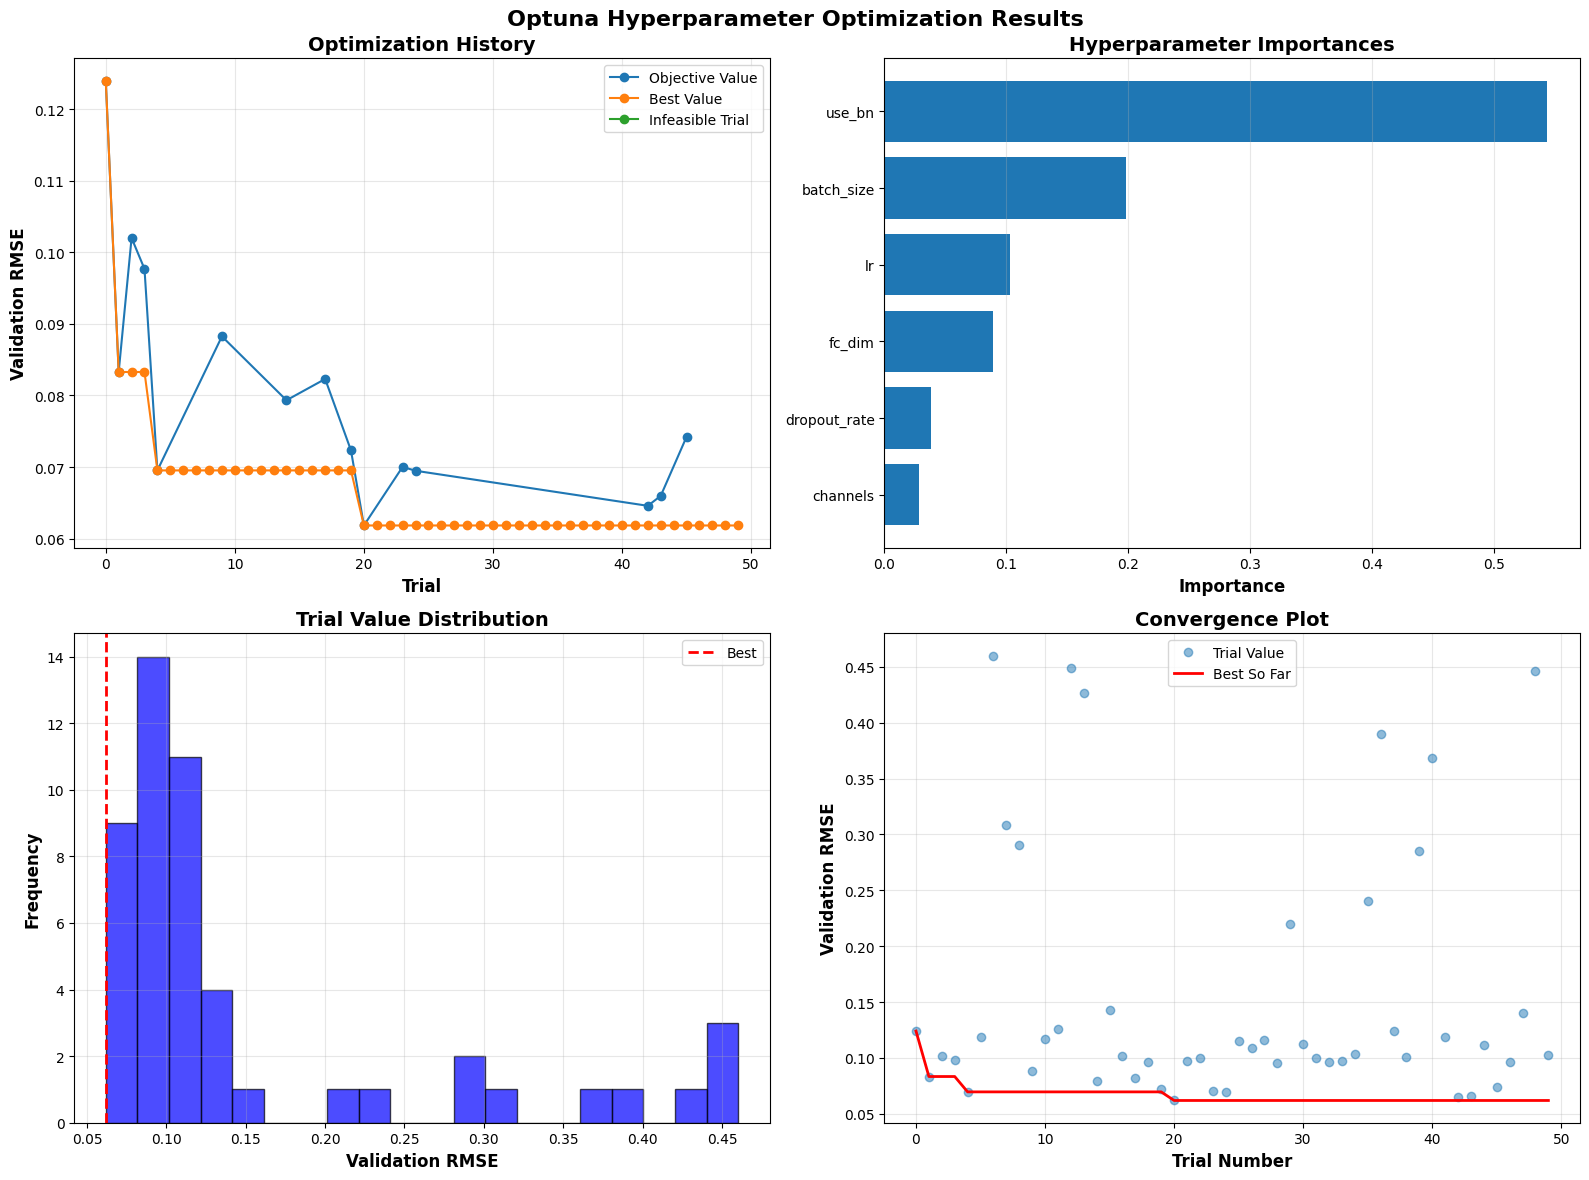

In [21]:
# Visualize Optuna results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Optimization history
ax1 = axes[0, 0]
optuna_fig1 = plot_optimization_history(study)
for trace in optuna_fig1.data:
    ax1.plot(trace.x, trace.y, marker='o', label=trace.name)
ax1.set_xlabel('Trial', fontweight='bold', fontsize=12)
ax1.set_ylabel('Validation RMSE', fontweight='bold', fontsize=12)
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Parameter importances
ax2 = axes[0, 1]
try:
    optuna_fig2 = plot_param_importances(study)
    importances = optuna_fig2.data[0]
    ax2.barh(importances.y, importances.x)
    ax2.set_xlabel('Importance', fontweight='bold', fontsize=12)
    ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3, axis='x')
except:
    ax2.text(0.5, 0.5, 'Not enough trials for importance analysis',
             ha='center', va='center', fontsize=12)
    ax2.axis('off')

# Trial value distribution
ax3 = axes[1, 0]
trial_values = [t.value for t in study.trials if t.value is not None]
ax3.hist(trial_values, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(study.best_trial.value, color='red', linestyle='--', linewidth=2, label='Best')
ax3.set_xlabel('Validation RMSE', fontweight='bold', fontsize=12)
ax3.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax3.set_title('Trial Value Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Best vs trial number
ax4 = axes[1, 1]
trial_numbers = [t.number for t in study.trials if t.value is not None]
cumulative_best = []
current_best = float('inf')
for t in study.trials:
    if t.value is not None and t.value < current_best:
        current_best = t.value
    cumulative_best.append(current_best if t.value is not None else None)
ax4.plot(trial_numbers, [t.value for t in study.trials if t.value is not None],
         'o', alpha=0.5, label='Trial Value')
ax4.plot(range(len(cumulative_best)), cumulative_best,
         'r-', linewidth=2, label='Best So Far')
ax4.set_xlabel('Trial Number', fontweight='bold', fontsize=12)
ax4.set_ylabel('Validation RMSE', fontweight='bold', fontsize=12)
ax4.set_title('Convergence Plot', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle('Optuna Hyperparameter Optimization Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_optuna_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Final Model Training & Analysis

Train final model with optimized hyperparameters.

In [22]:
# Extract best hyperparameters
best_params = study.best_trial.params

print("Training final model with optimized hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Training final model with optimized hyperparameters:
  channels: [32, 64, 128, 256, 512]
  fc_dim: 512
  dropout_rate: 0.34251086540581305
  lr: 0.00018130427581433087
  batch_size: 32
  use_bn: True


In [23]:
# Initialize final model
final_model = VanillaCNN_Regression(
    channels=best_params['channels'],
    fc_dim=best_params['fc_dim'],
    dropout_rate=best_params['dropout_rate'],
    use_bn=best_params['use_bn']
).to(device)

# Create dataloaders with best batch size
final_train_loader = DataLoader(
    train_subset, batch_size=best_params['batch_size'], shuffle=True,
    num_workers=0, pin_memory=False
)
final_val_loader = DataLoader(
    val_subset, batch_size=best_params['batch_size'], shuffle=False,
    num_workers=0, pin_memory=False
)
final_test_loader = DataLoader(
    test_subset, batch_size=best_params['batch_size'], shuffle=False,
    num_workers=0, pin_memory=False
)

# Loss and optimizer
final_criterion = nn.MSELoss()
final_optimizer = torch.optim.AdamW(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=1e-4
)

# Scheduler
final_scheduler = CosineAnnealingWarmRestarts(
    final_optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# Tracker
final_tracker = RegressionMetricsTracker()

print(f"\nFinal model initialized with {final_model.get_num_params():,} parameters")


Final model initialized with 1,833,729 parameters


In [24]:
# Training configuration
num_epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

print(f"Starting final model training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    # Train
    train_metrics = train_epoch_regression(
        model=final_model,
        dataloader=final_train_loader,
        criterion=final_criterion,
        optimizer=final_optimizer,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=final_model,
        dataloader=final_val_loader,
        criterion=final_criterion,
        device=device
    )
    
    # Update learning rate
    final_scheduler.step()
    current_lr = final_optimizer.param_groups[0]['lr']
    
    # Update tracker
    final_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}")
        print(f"  LR: {current_lr:.6f}")
    
    # Early stopping
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        # Save best model
        best_final_model_state = final_model.state_dict()
        print(f"  -> New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print(f"\nFinal model training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
final_model.load_state_dict(best_final_model_state)

Starting final model training for 100 epochs...

Epoch [1/100]
  Train - Loss: 0.0390, RMSE: 0.1975, MAE: 0.1443
  Val   - Loss: 0.2364, RMSE: 0.4862, MAE: 0.3850
  LR: 0.000177
  -> New best validation loss: 0.2364
  -> New best validation loss: 0.0488
  -> New best validation loss: 0.0116
Epoch [5/100]
  Train - Loss: 0.0144, RMSE: 0.1201, MAE: 0.0900
  Val   - Loss: 0.0164, RMSE: 0.1280, MAE: 0.0963
  LR: 0.000091
  -> New best validation loss: 0.0101
  -> New best validation loss: 0.0073
  -> New best validation loss: 0.0067
  -> New best validation loss: 0.0064
Epoch [10/100]
  Train - Loss: 0.0110, RMSE: 0.1051, MAE: 0.0779
  Val   - Loss: 0.0068, RMSE: 0.0823, MAE: 0.0621
  LR: 0.000181
Epoch [15/100]
  Train - Loss: 0.0111, RMSE: 0.1052, MAE: 0.0791
  Val   - Loss: 0.0045, RMSE: 0.0673, MAE: 0.0514
  LR: 0.000155
  -> New best validation loss: 0.0045
Epoch [20/100]
  Train - Loss: 0.0086, RMSE: 0.0927, MAE: 0.0712
  Val   - Loss: 0.0340, RMSE: 0.1844, MAE: 0.1608
  LR: 0.000091

<All keys matched successfully>

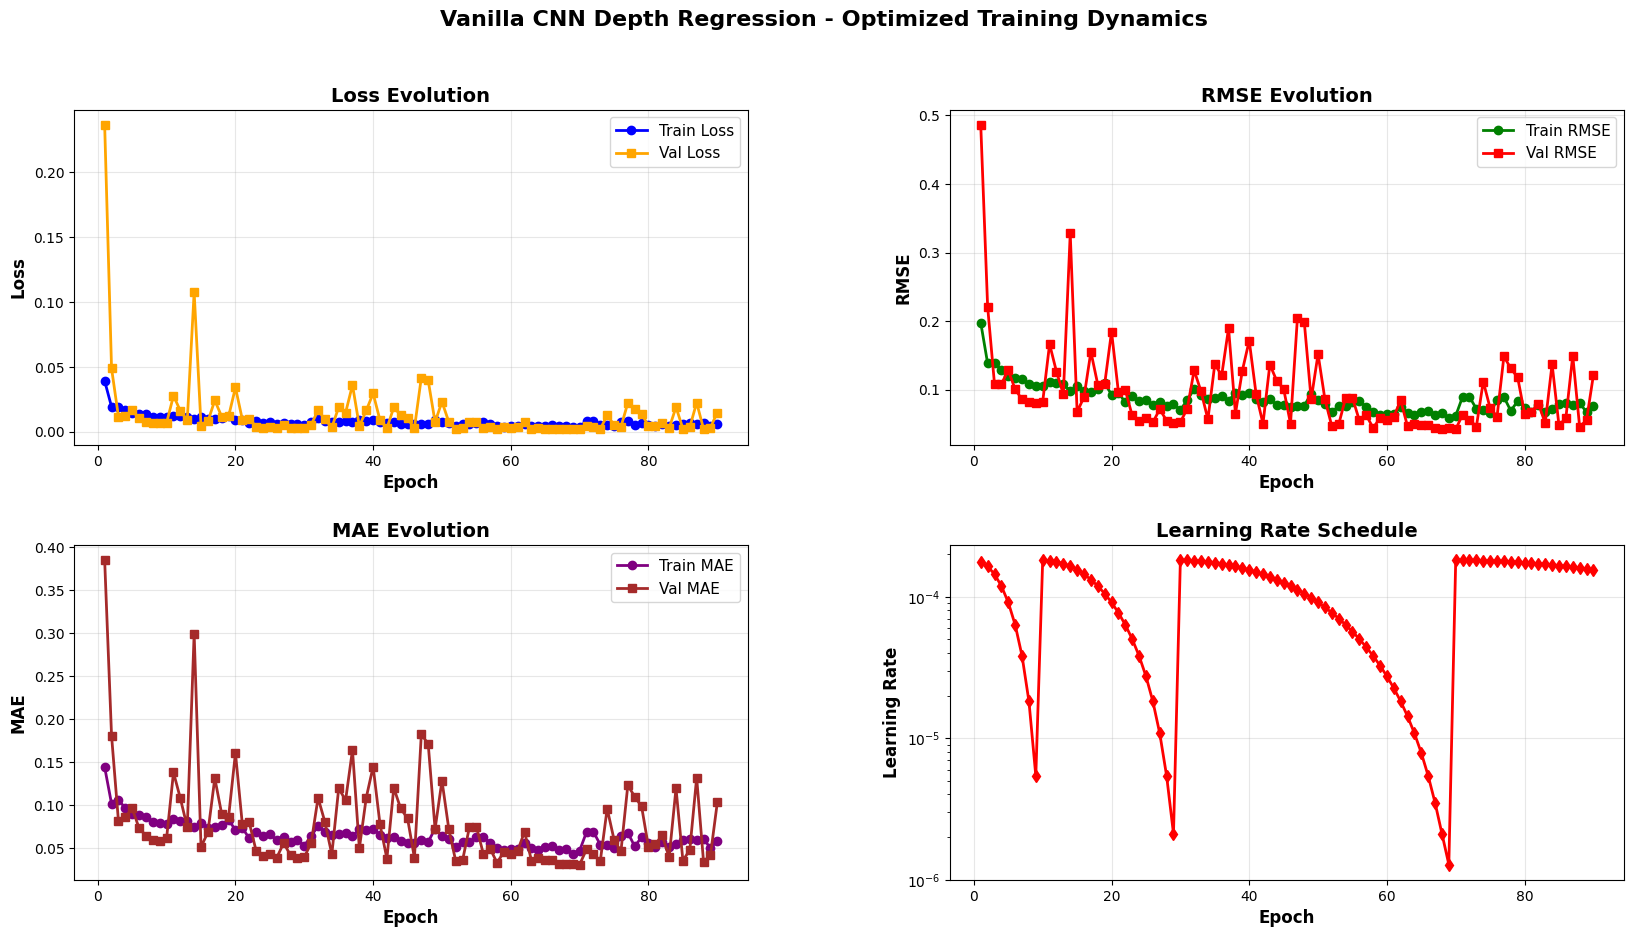

In [25]:
# Plot final training curves
plot_regression_training_curves(
    tracker_history=final_tracker.get_history(),
    save_path=reports_dir / '7_vanilla_cnn_depth_optimized_training_curves.png',
    title='Vanilla CNN Depth Regression - Optimized Training Dynamics'
)

In [26]:
# Evaluate on test set
final_test_results = collect_predictions_regression(
    model=final_model,
    dataloader=final_test_loader,
    device=device,
    return_images=True
)

final_test_metrics = compute_regression_metrics(
    predictions=final_test_results['predictions'],
    targets=final_test_results['targets']
)

print("\nFinal Test Set Performance:")
print("="*50)
print(f"MSE:           {final_test_metrics['mse']:.6f}")
print(f"RMSE:          {final_test_metrics['rmse']:.6f}")
print(f"MAE:           {final_test_metrics['mae']:.6f}")
print(f"Median AE:     {final_test_metrics['median_ae']:.6f}")
print(f"R²:            {final_test_metrics['r2']:.6f}")
print(f"Max Error:     {final_test_metrics['max_error']:.6f}")
print(f"Std Error:     {final_test_metrics['std_error']:.6f}")
if 'mape' in final_test_metrics:
    print(f"MAPE:          {final_test_metrics['mape']:.2f}%")
print("="*50)


Final Test Set Performance:
MSE:           0.016653
RMSE:          0.129048
MAE:           0.111999
Median AE:     0.110345
R²:            0.833770
Max Error:     0.279203
Std Error:     0.070450


In [27]:
# Compare baseline vs optimized
print("\nPerformance Comparison:")
print("="*60)
print(f"{'Metric':<15} {'Baseline':<20} {'Optimized':<20} {'Improvement'}")
print("="*60)

metrics_to_compare = ['rmse', 'mae', 'r2']
for metric in metrics_to_compare:
    baseline_val = test_metrics[metric]
    optimized_val = final_test_metrics[metric]
    
    if metric == 'r2':
        improvement = ((optimized_val - baseline_val) / abs(baseline_val)) * 100
        print(f"{metric.upper():<15} {baseline_val:<20.6f} {optimized_val:<20.6f} {improvement:+.2f}%")
    else:
        improvement = ((baseline_val - optimized_val) / baseline_val) * 100
        print(f"{metric.upper():<15} {baseline_val:<20.6f} {optimized_val:<20.6f} {improvement:+.2f}%")

print("="*60)


Performance Comparison:
Metric          Baseline             Optimized            Improvement
RMSE            0.083674             0.129048             -54.23%
MAE             0.068694             0.111999             -63.04%
R2              0.930115             0.833770             -10.36%


In [ ]:
# Save final model
final_model_path = models_dir / '5_vanilla_cnn_depth_baseline.pth'
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': final_optimizer.state_dict(),
    'best_params': best_params,
    'best_val_loss': best_val_loss,
    'test_metrics': final_test_metrics,
    'tracker_history': final_tracker.get_history()
}, final_model_path)

print(f"Final model saved to: {final_model_path}")

Final model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/7_vanilla_cnn_depth_final.pth


## Best model was the first implementation, not the one resulted of the optimization process

## 7. Advanced Visualizations

Comprehensive visual analysis of model predictions and errors.

### 7.1 Depth Predictions Gallery

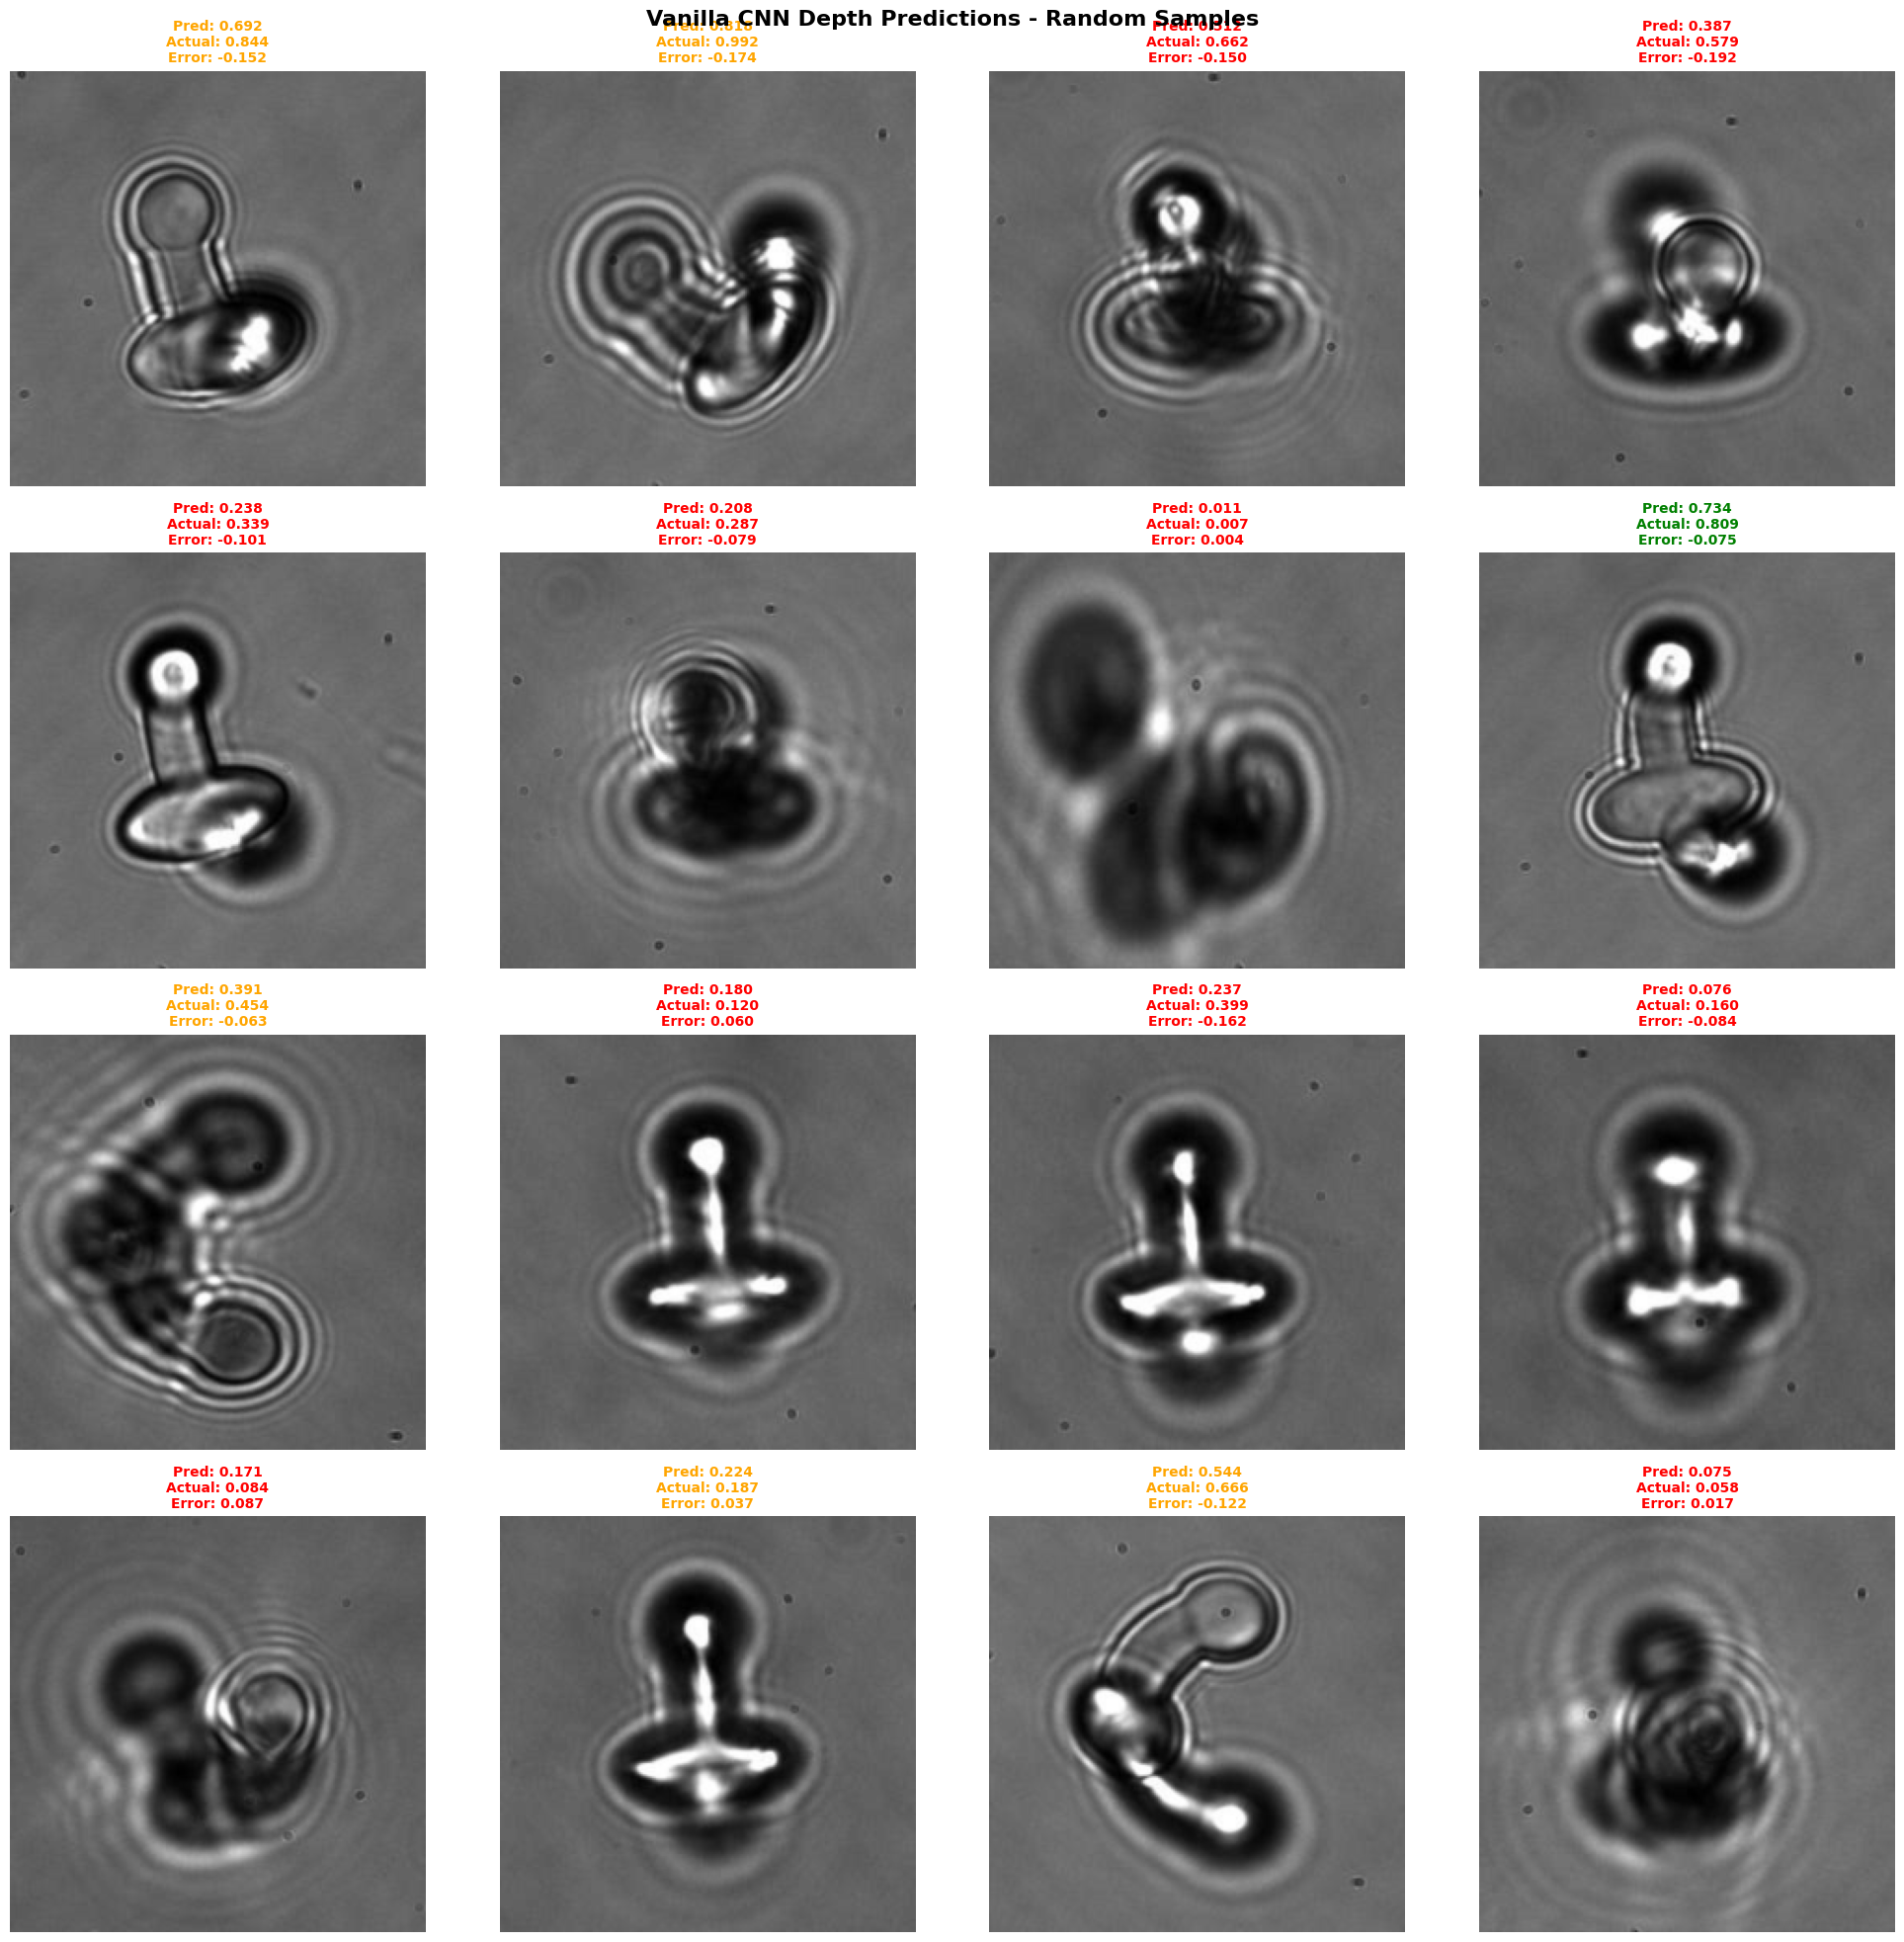

In [33]:
# Random sample of predictions
plot_depth_predictions_gallery(
    images=test_results['images'],
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    num_samples=16,
    save_path=reports_dir / '7_vanilla_cnn_depth_predictions_gallery.png',
    title='Vanilla CNN Depth Predictions - Random Samples'
)

### 7.2 Best and Worst Predictions

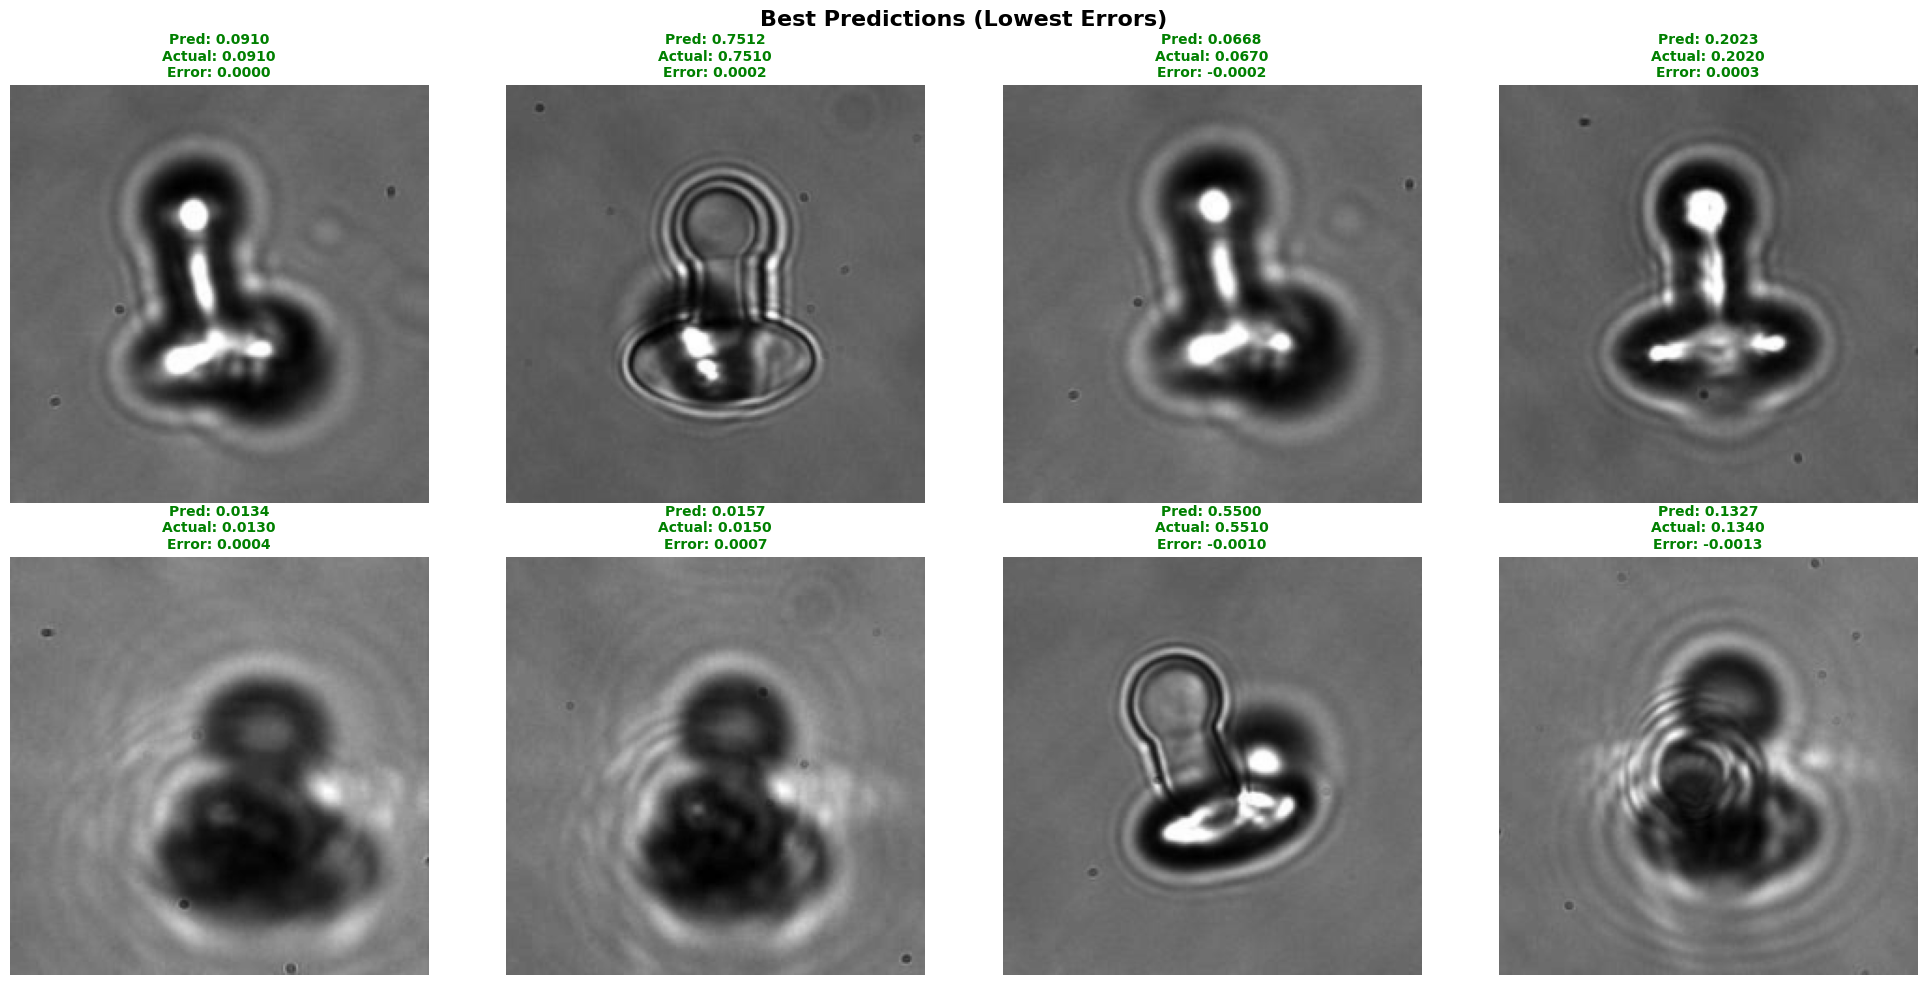

In [34]:
# Find best and worst predictions
errors = np.abs(   test_results['predictions'] -  test_results['targets'])
best_indices = np.argsort(errors)[:8]
worst_indices = np.argsort(errors)[-8:]

# Visualize best predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(best_indices):
    img =  test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target =   test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='green'
    )

plt.suptitle('Best Predictions (Lowest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_best_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

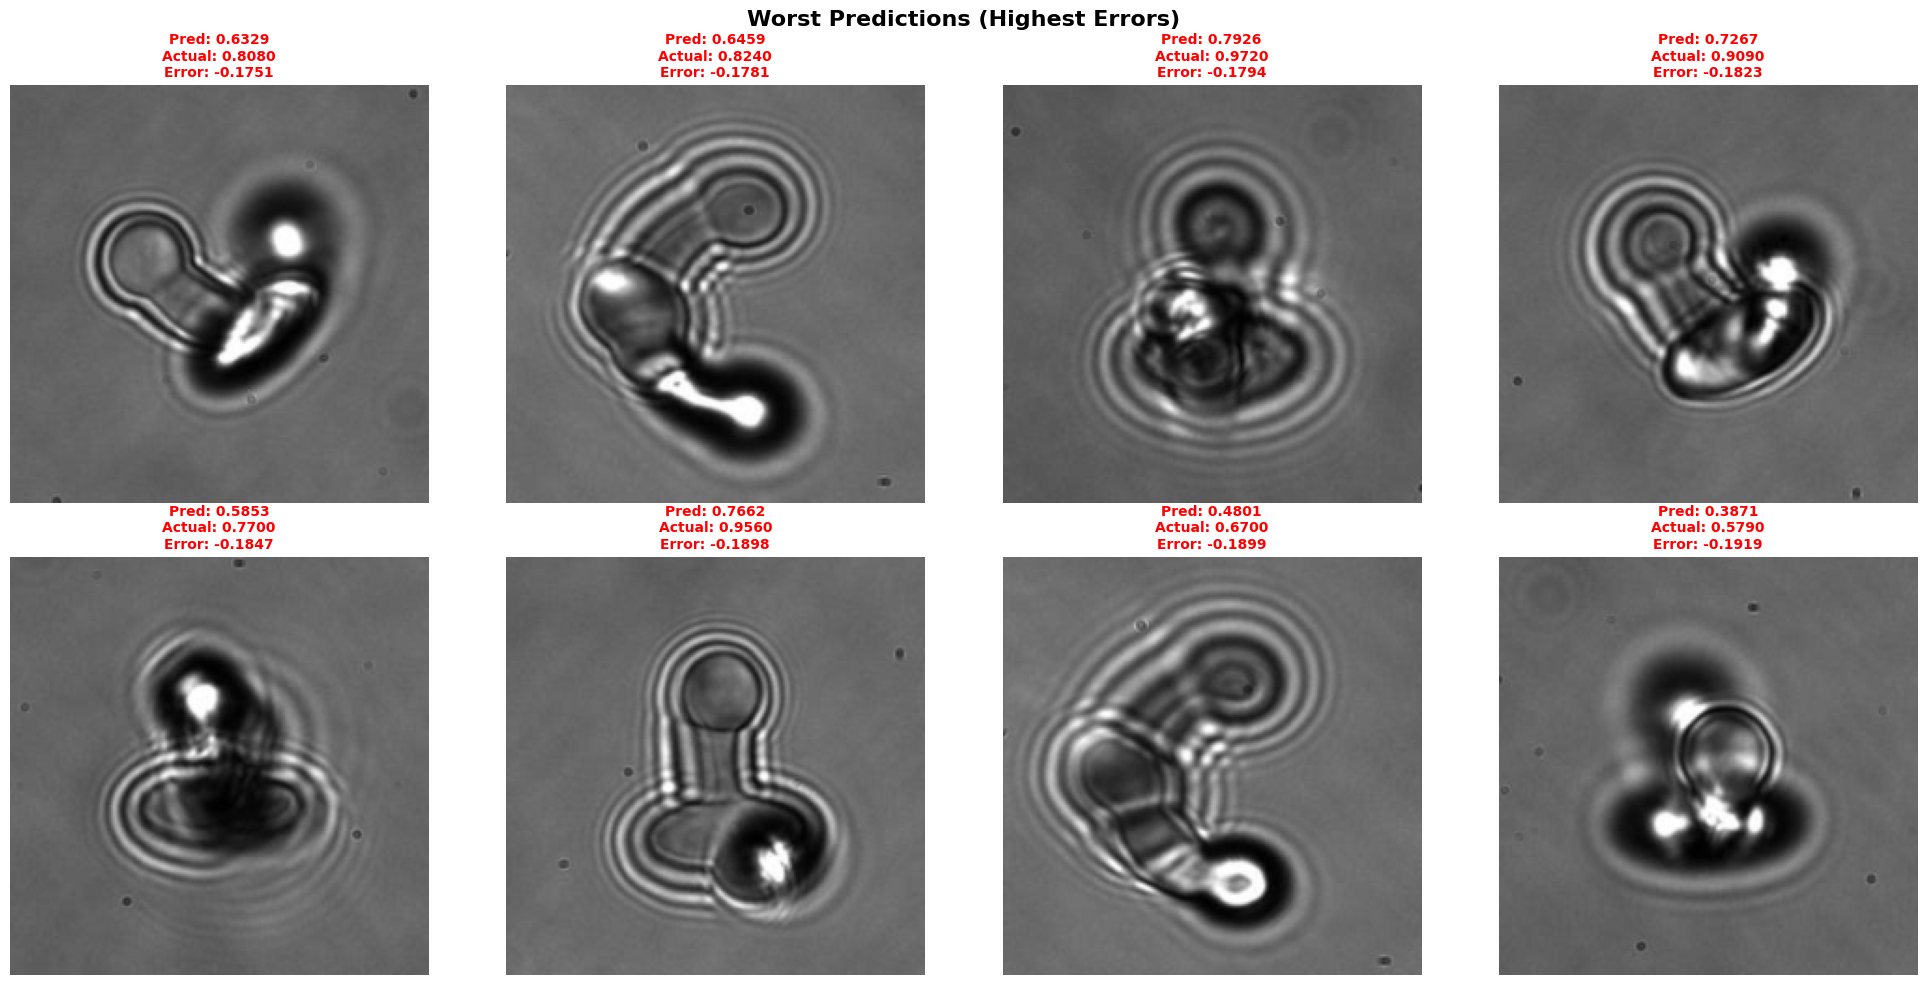

In [35]:
# Visualize worst predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(worst_indices):
    img = test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='red'
    )

plt.suptitle('Worst Predictions (Highest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_worst_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.3 Error Analysis by Depth Range

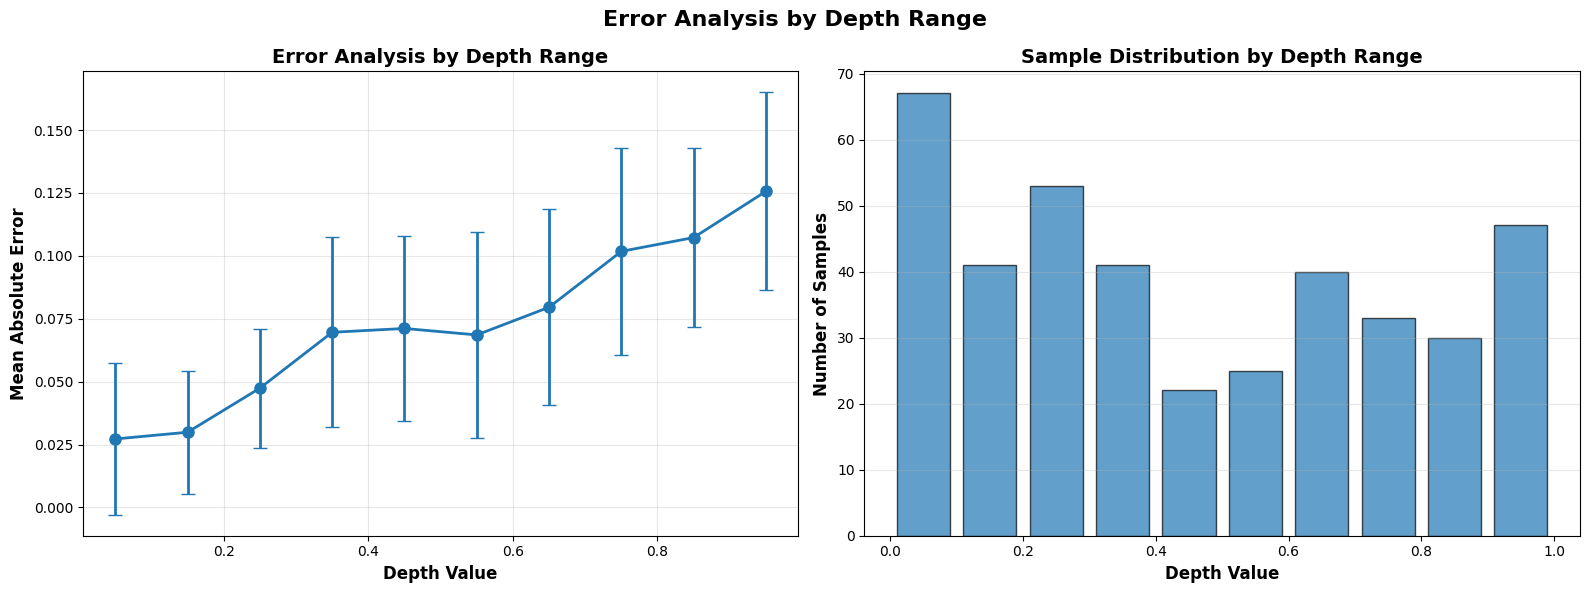

In [38]:
# Analyze errors by depth range
targets = test_results['targets']
predictions = test_results['predictions']
abs_errors = np.abs(predictions - targets)

# Create depth bins
num_bins = 10
depth_bins = np.linspace(targets.min(), targets.max(), num_bins + 1)
bin_indices = np.digitize(targets, depth_bins) - 1

# Calculate statistics per bin
bin_centers = []
bin_mean_errors = []
bin_std_errors = []
bin_counts = []

for i in range(num_bins):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        bin_centers.append((depth_bins[i] + depth_bins[i+1]) / 2)
        bin_mean_errors.append(np.mean(abs_errors[mask]))
        bin_std_errors.append(np.std(abs_errors[mask]))
        bin_counts.append(np.sum(mask))

# Plot error analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error vs depth range
axes[0].errorbar(bin_centers, bin_mean_errors, yerr=bin_std_errors,
                 marker='o', markersize=8, capsize=5, linewidth=2)
axes[0].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].set_title('Error Analysis by Depth Range', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Sample distribution by depth range
axes[1].bar(bin_centers, bin_counts, width=(depth_bins[1]-depth_bins[0])*0.8,
            alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
axes[1].set_title('Sample Distribution by Depth Range', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('Error Analysis by Depth Range', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_error_by_range.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.4 Feature Map Visualization

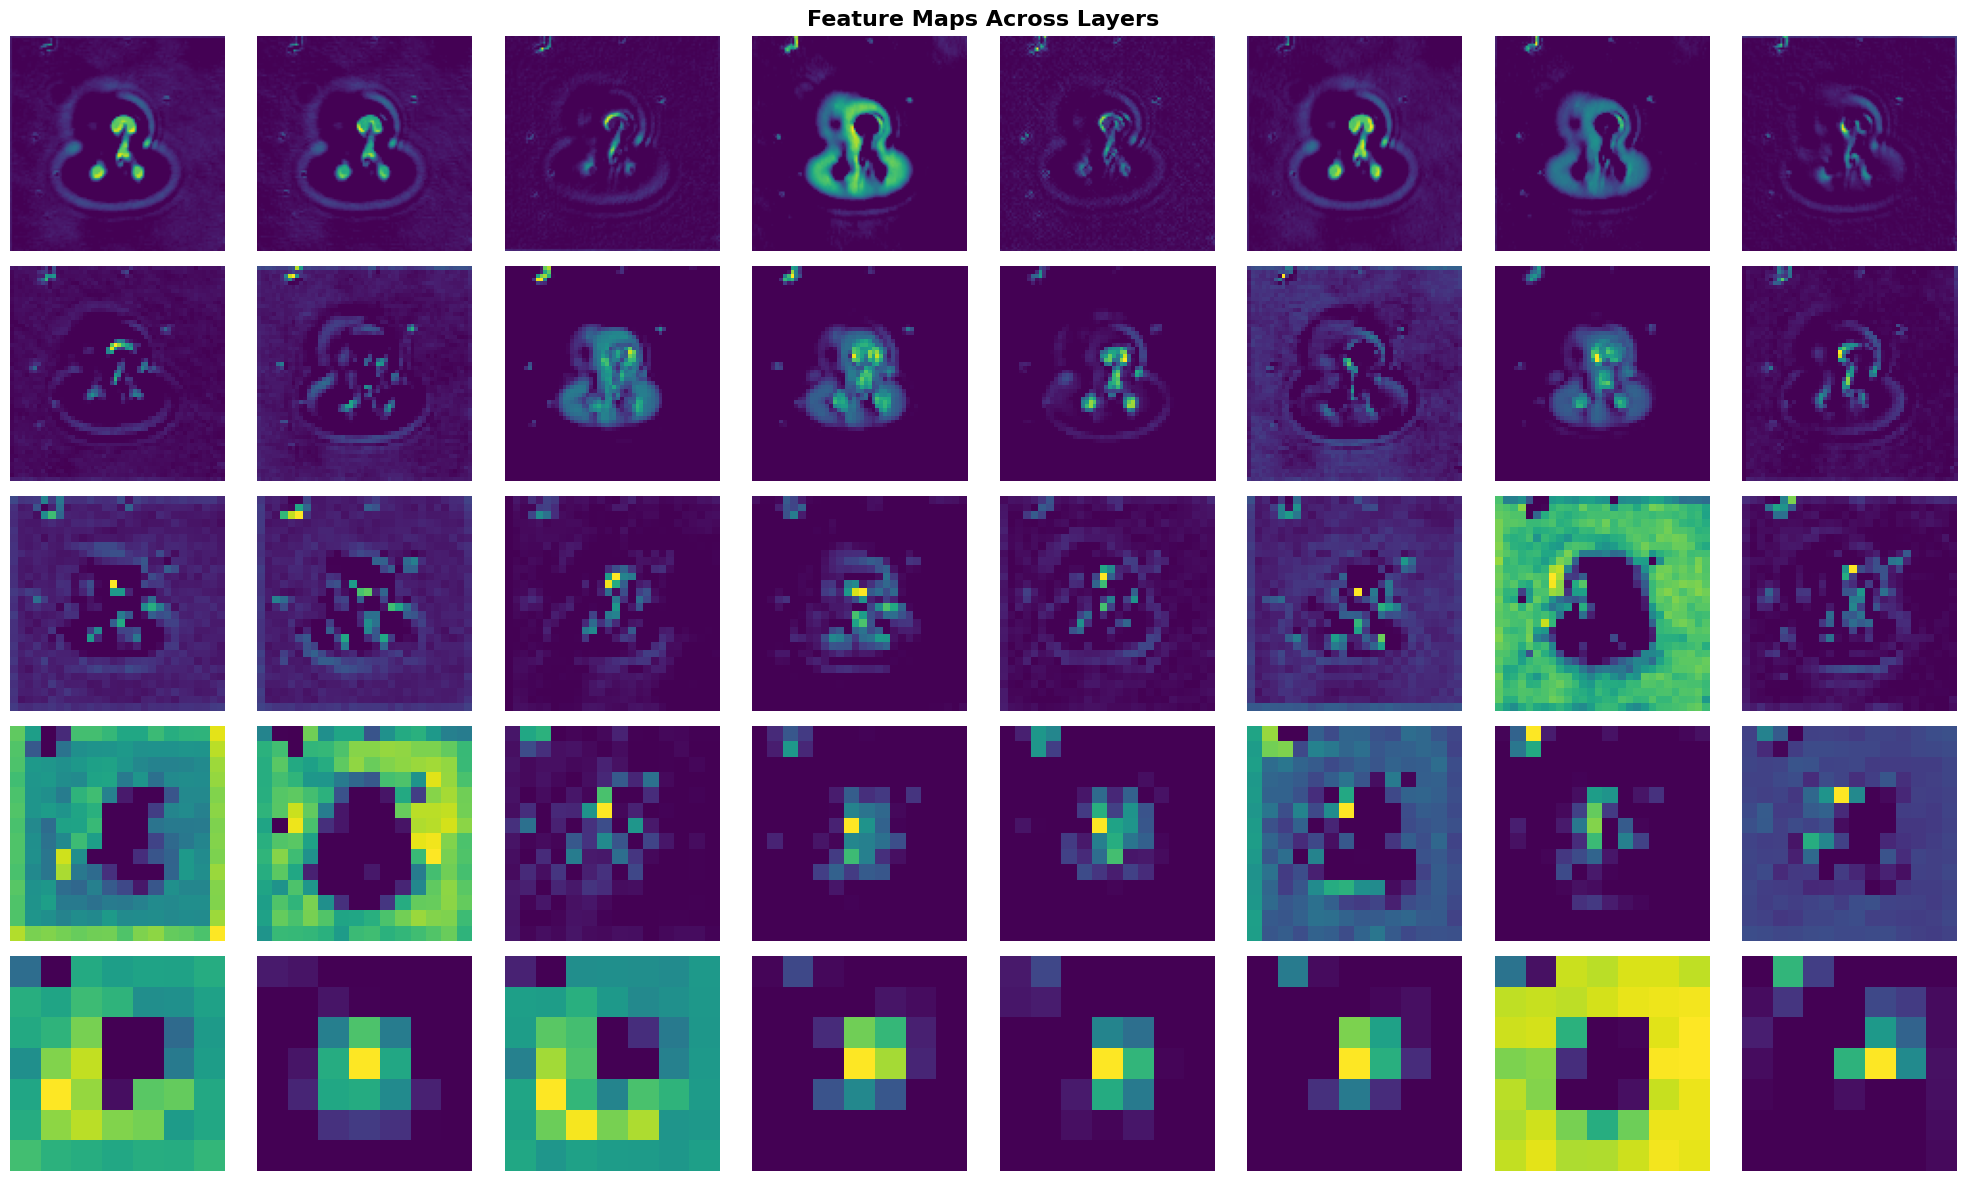

In [40]:
# Get a sample image
sample_idx = 0
sample_img = test_results['images'][sample_idx:sample_idx+1]
sample_img_tensor = torch.from_numpy(sample_img).to(device)

# Extract feature maps from each layer
model.eval()
activations = []

with torch.no_grad():
    x = sample_img_tensor
    for i, block in enumerate(model.features):
        x = block(x)
        activations.append(x.cpu().numpy())

# Visualize feature maps from each layer
fig = plt.figure(figsize=(20, 12))
num_layers = len(activations)

for layer_idx in range(num_layers):
    activation = activations[layer_idx][0]  # First sample
    num_channels = min(8, activation.shape[0])  # Show max 8 channels
    
    for ch_idx in range(num_channels):
        ax = plt.subplot(num_layers, 8, layer_idx * 8 + ch_idx + 1)
        ax.imshow(activation[ch_idx], cmap='viridis')
        ax.axis('off')
        if ch_idx == 0:
            ax.set_ylabel(f'Layer {layer_idx+1}', fontweight='bold', fontsize=10)

plt.suptitle('Feature Maps Across Layers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.5 Grad-CAM for Regression

Visualize which regions the model focuses on for depth prediction.

In [41]:
def generate_gradcam_regression(model, img_tensor, target_layer):
    """
    Generate Grad-CAM heatmap for regression model
    
    Args:
        model: Regression model
        img_tensor: Input image tensor (1, C, H, W)
        target_layer: Layer to generate CAM from
    
    Returns:
        heatmap: Grad-CAM heatmap
    """
    model.eval()
    
    # Forward pass and get activations
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass
    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    
    # Backward pass (maximize output for regression)
    model.zero_grad()
    output.backward()
    
    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()
    
    # Get gradients and activations
    grads = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]
    
    # Weight channels by gradient
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * acts[i]
    
    # Apply ReLU
    cam = np.maximum(cam, 0)
    
    # Normalize
    if cam.max() > 0:
        cam = cam / cam.max()
    
    return cam

print("Grad-CAM function defined")

Grad-CAM function defined


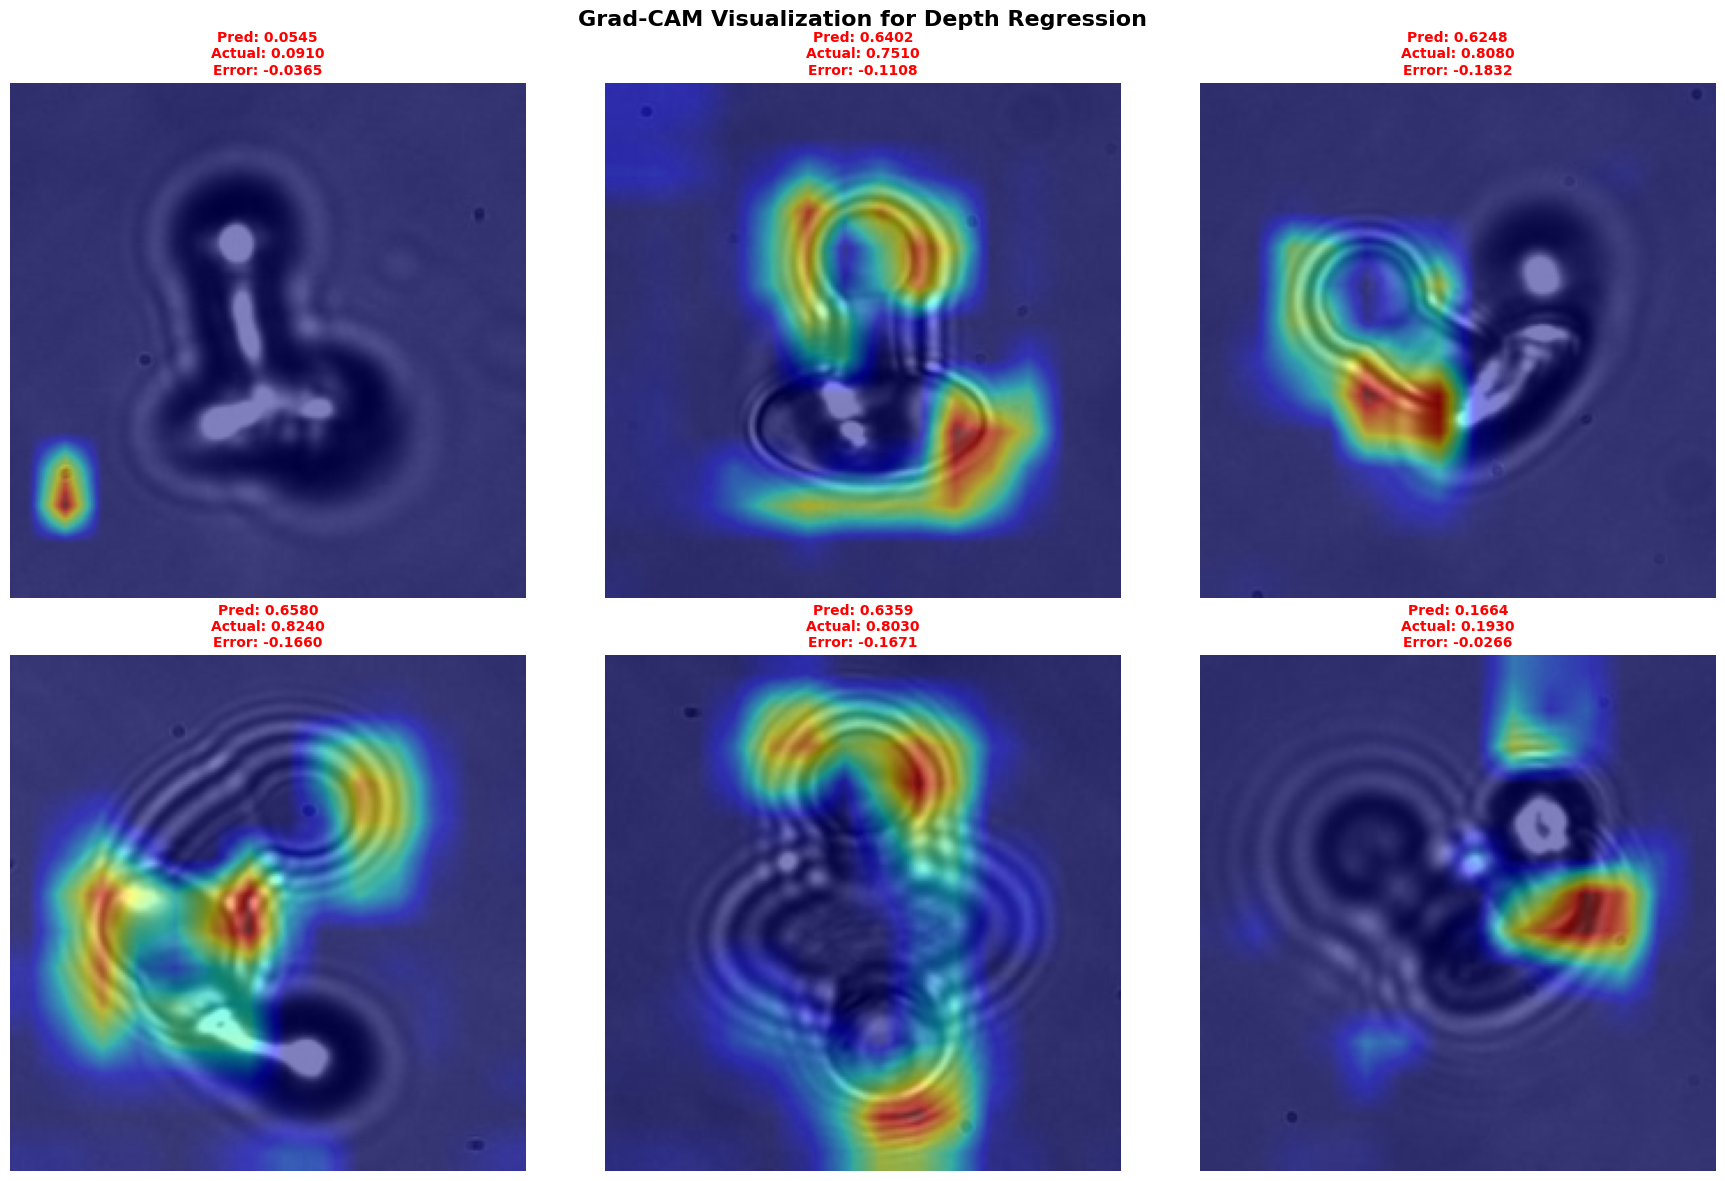

In [42]:
# Generate Grad-CAM for selected samples
import cv2

# Select samples (best, worst, and random)
sample_indices = [
    best_indices[0],
    best_indices[1],
    worst_indices[0],
    worst_indices[1],
    np.random.randint(0, len(final_test_results['images'])),
    np.random.randint(0, len(final_test_results['images']))
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Use last convolutional layer
target_layer = final_model.features[-1][0]  # Last conv layer

for i, idx in enumerate(sample_indices):
    # Get image
    img = final_test_results['images'][idx]
    img_tensor = torch.from_numpy(img[np.newaxis, :]).to(device)
    
    # Get prediction
    pred = final_test_results['predictions'][idx]
    target = final_test_results['targets'][idx]
    error = pred - target
    
    # Generate Grad-CAM
    heatmap = generate_gradcam_regression(final_model, img_tensor, target_layer)
    
    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    # Overlay heatmap
    axes[i].imshow(img_display)
    axes[i].imshow(heatmap_resized, cmap='jet', alpha=0.5)
    axes[i].axis('off')
    
    # Color based on error
    color = 'green' if abs(error) < 0.01 else 'red'
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color=color
    )

plt.suptitle('Grad-CAM Visualization for Depth Regression', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '7_vanilla_cnn_depth_gradcam.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Optimized Vanilla CNN for Depth Regression

Based on the optimized architecture from hyperparameter tuning for classification, we now train an optimized version for depth regression with:
- **Optimized channels**: `[48, 32, 128, 128, 64]` (vs baseline `[32, 64, 128, 256, 512]`)
- **Larger FC dimension**: 384 (vs 256)
- **Lower dropout**: 0.3 (vs 0.5)

This architecture was found to be more efficient with better accuracy-to-parameter ratio.

In [ ]:
# Alias for consistency
VanillaCNNRegression = VanillaCNN_Regression

# Initialize optimized model with tuned hyperparameters
optimized_model = VanillaCNNRegression(
    channels=[48, 32, 128, 128, 64],  # Optimized channel configuration
    fc_dim=384,                        # Larger FC dimension
    dropout_rate=0.3,                  # Lower dropout
    use_bn=True
).to(device)

# Store reference to baseline model
baseline_model = model

# Loss and optimizer
criterion_opt = nn.MSELoss()
optimizer_opt = torch.optim.AdamW(
    optimized_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler_opt = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_opt,
    T_max=20,
    eta_min=1e-6
)

# Metrics tracker
tracker_opt = RegressionMetricsTracker()

print("Optimized Vanilla CNN Regression Model")
print(f"  Channels: [48, 32, 128, 128, 64]")
print(f"  FC dim: 384")
print(f"  Dropout: 0.3")
print(f"  Total parameters: {sum(p.numel() for p in optimized_model.parameters()):,}")
print(f"\nBaseline had {sum(p.numel() for p in baseline_model.parameters()):,} parameters")
print(f"Parameter reduction: {(1 - sum(p.numel() for p in optimized_model.parameters())/sum(p.numel() for p in baseline_model.parameters()))*100:.1f}%")

Optimized Vanilla CNN Regression Model
  Channels: [48, 32, 128, 128, 64]
  FC dim: 384
  Dropout: 0.3
  Total parameters: 299,713

Baseline had 1,702,145 parameters
Parameter reduction: 82.4%


In [ ]:
# Training loop for optimized model (20 epochs)
num_epochs_opt = 20
best_val_rmse_opt = float('inf')
best_model_state_opt = None

print("Training Optimized Vanilla CNN for 20 epochs...\n")
print("=" * 80)

for epoch in range(1, num_epochs_opt + 1):
    # Train
    train_metrics = train_epoch_regression(
        model=optimized_model,
        dataloader=train_loader,
        criterion=criterion_opt,
        optimizer=optimizer_opt,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=optimized_model,
        dataloader=val_loader,
        criterion=criterion_opt,
        device=device
    )
    
    # Update scheduler
    scheduler_opt.step()
    current_lr = optimizer_opt.param_groups[0]['lr']
    
    # Track metrics
    tracker_opt.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    print(f"Epoch [{epoch:02d}/{num_epochs_opt}]")
    print(f"  Train - Loss: {train_metrics['loss']:.6f}, RMSE: {train_metrics['rmse']:.6f}, MAE: {train_metrics['mae']:.6f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.6f}, RMSE: {val_metrics['rmse']:.6f}, MAE: {val_metrics['mae']:.6f}")
    print(f"  LR: {current_lr:.6f}")
    
    # Save best model
    if val_metrics['rmse'] < best_val_rmse_opt:
        best_val_rmse_opt = val_metrics['rmse']
        best_model_state_opt = optimized_model.state_dict().copy()
        print(f"  -> New best validation RMSE: {best_val_rmse_opt:.6f}")

print("\n" + "=" * 80)
print(f"Training completed!")
print(f"Best validation RMSE: {best_val_rmse_opt:.6f}")

# Load best model
if best_model_state_opt is not None:
    optimized_model.load_state_dict(best_model_state_opt)
    print("Loaded best model weights")

Training Optimized Vanilla CNN for 20 epochs...

Epoch [01/20]
  Train - Loss: 0.068000, RMSE: 0.260767, MAE: 0.179391
  Val   - Loss: 0.230202, RMSE: 0.479793, MAE: 0.376828
  LR: 0.000994
  -> New best validation RMSE: 0.479793
Epoch [02/20]
  Train - Loss: 0.019516, RMSE: 0.139700, MAE: 0.105150
  Val   - Loss: 0.241625, RMSE: 0.491554, MAE: 0.388639
  LR: 0.000976
Epoch [03/20]
  Train - Loss: 0.015187, RMSE: 0.123237, MAE: 0.091868
  Val   - Loss: 0.201675, RMSE: 0.449083, MAE: 0.366987
  LR: 0.000946
  -> New best validation RMSE: 0.449083
Epoch [04/20]
  Train - Loss: 0.015261, RMSE: 0.123536, MAE: 0.090156
  Val   - Loss: 0.010253, RMSE: 0.101257, MAE: 0.076963
  LR: 0.000905
  -> New best validation RMSE: 0.101257
Epoch [05/20]
  Train - Loss: 0.013682, RMSE: 0.116971, MAE: 0.086917
  Val   - Loss: 0.022508, RMSE: 0.150026, MAE: 0.112182
  LR: 0.000854
Epoch [06/20]
  Train - Loss: 0.013169, RMSE: 0.114758, MAE: 0.085313
  Val   - Loss: 0.009319, RMSE: 0.096534, MAE: 0.070759


### 8.1 Training Curves

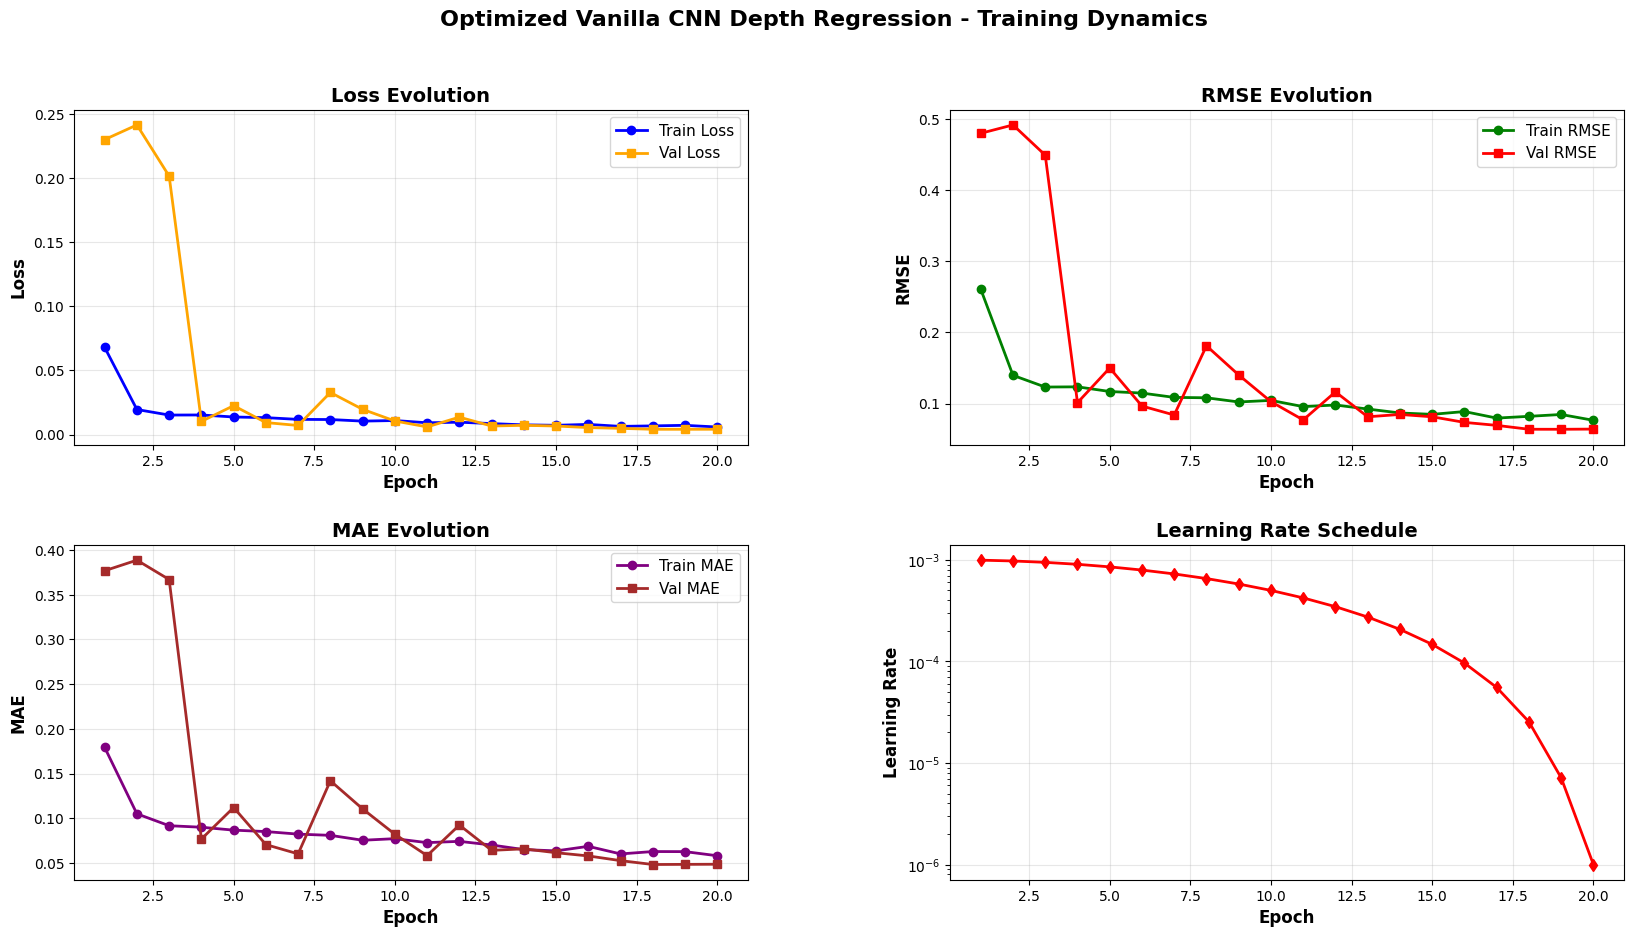

In [ ]:
# Plot optimized model training curves
plot_regression_training_curves(
    tracker_history=tracker_opt.get_history(),
    save_path=project_root/"reports" / '7_vanilla_cnn_depth_optimized_regression_training_curves.png',
    title='Optimized Vanilla CNN Depth Regression - Training Dynamics'
)

### 8.2 Test Set Evaluation

In [ ]:
# Collect predictions on test set for optimized model
test_results_opt = collect_predictions_regression(
    model=optimized_model,
    dataloader=test_loader,
    device=device,
    return_images=True
)

print("Optimized model - Test set predictions collected")
print(f"   Predictions shape: {test_results_opt['predictions'].shape}")
print(f"   Targets shape: {test_results_opt['targets'].shape}")
print(f"   Images shape: {test_results_opt['images'].shape}")

Optimized model - Test set predictions collected
   Predictions shape: (400,)
   Targets shape: (400,)
   Images shape: (400, 3, 224, 224)


In [ ]:
# Compute comprehensive metrics for optimized model
test_metrics_opt = compute_regression_metrics(
    predictions=test_results_opt['predictions'],
    targets=test_results_opt['targets']
)

print("\nOptimized Model - Test Set Performance:")
print("="*50)
print(f"MSE:           {test_metrics_opt['mse']:.6f}")
print(f"RMSE:          {test_metrics_opt['rmse']:.6f}")
print(f"MAE:           {test_metrics_opt['mae']:.6f}")
print(f"Median AE:     {test_metrics_opt['median_ae']:.6f}")
print(f"R²:            {test_metrics_opt['r2']:.6f}")
print(f"Max Error:     {test_metrics_opt['max_error']:.6f}")
print(f"Std Error:     {test_metrics_opt['std_error']:.6f}")
if 'mape' in test_metrics_opt:
    print(f"MAPE:          {test_metrics_opt['mape']:.2f}%")
print("="*50)


Optimized Model - Test Set Performance:
MSE:           0.003657
RMSE:          0.060475
MAE:           0.045479
Median AE:     0.036202
R²:            0.963495
Max Error:     0.234533
Std Error:     0.060374


In [ ]:
# Save optimized regression model
optimized_model_path = project_root / 'models' / '6_vanilla_cnn_optimized_depth_best.pth'
torch.save({
    'model_state_dict': optimized_model.state_dict(),
    'optimizer_state_dict': optimizer_opt.state_dict(),
    'best_val_rmse': best_val_rmse_opt,
    'test_metrics': test_metrics_opt,
    'tracker_history': tracker_opt.get_history(),
    'architecture': {
        'channels': [48, 32, 128, 128, 64],
        'fc_dim': 384,
        'dropout_rate': 0.3,
        'use_bn': True
    }
}, optimized_model_path)

print(f"Optimized regression model saved to: {optimized_model_path}")

Optimized regression model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/vanilla_cnn_optimized_depth_best.pth
